# **Required Libraries**

In [54]:
import yfinance as yf
import pandas as pd
from datetime import datetime
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings("ignore")

# **Question 1**

In [43]:
start_date = "2022-08-30"
end_date = "2024-09-30"

In [44]:
exchange_tickers = ["ZAR=X", "AUDUSD=X", "GBPUSD=X"]
exchange_data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in exchange_tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [45]:
for ticker, data in exchange_data.items():
    print(f"Data for {ticker}")
    print(data.head())

Data for ZAR=X
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2022-08-30  16.809641  16.972799  16.745100  16.809641  16.809641       0
2022-08-31  16.957800  17.087179  16.858629  16.957800  16.957800       0
2022-09-01  17.105209  17.304930  17.088301  17.105209  17.105209       0
2022-09-02  17.251900  17.345699  17.172701  17.251900  17.251900       0
2022-09-05  17.300900  17.418039  17.146500  17.300900  17.300900       0
Data for AUDUSD=X
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2022-08-30  0.690751  0.695797  0.685990  0.690751   0.690751       0
2022-08-31  0.685740  0.690422  0.684340  0.685740   0.685740       0
2022-09-01  0.682850  0.684360  0.677172  0.682850   0.682850       0
2022-09-02  0.679530  0.685380  0.678109  0.679530   0.679530       0
2022-09-05  0.679030  0.68041

In [46]:
def calculate_returns(df):
    df['Returns'] = df['Adj Close'].pct_change().dropna() * 100
    return df['Returns'].dropna()

In [47]:
def fit_garch_model(returns, model_type='GARCH'):
    if model_type == 'ARCH':
        model = arch_model(returns, vol='Arch', p=1)
    elif model_type == 'GARCH':
        model = arch_model(returns, vol='Garch', p=1, q=1)
    elif model_type == 'EGARCH':
        model = arch_model(returns, vol='EGarch', p=1, q=1)
    elif model_type == 'TGARCH':
        model = arch_model(returns, vol='Garch', p=1, o=1, q=1)
    elif model_type == 'PGARCH':
        model = arch_model(returns, p=1, q=1, o=1, power=1.0)
    else:
        raise ValueError(f"Unsupport model type: {model_type}")
    
    model_fit = model.fit(disp='off')
    return model_fit

In [48]:
def visualize_results(returns, model_results, title):

    # plot returns
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.plot(returns, label='Returns', color='blue')
    plt.title(f"Daily Returns for {title}", fontsize=20, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()

    # plot volatility
    plt.subplot(2, 1, 2)
    plt.plot(model_results.conditional_volatility, label='Conditional Volatility', color='red')
    plt.title(f"Conditional Volatility for {title}", fontsize=20, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [65]:
def compare_volatility_forecasting(returns, models):

    realized_volatility = returns**2
    forecast_errors = {}

    for model_name, model_results in models.items():
        forecasted_volatility = model_results.conditional_volatility

        mse = np.mean((realized_volatility - forecasted_volatility**2)**2)

        forecast_errors[model_name] = mse

        print(f"{model_name} - Volatility Forecasting MSE: {mse}")

    best_model = min(forecast_errors, key=forecast_errors.get)
    
    return best_model

In [73]:
def evaluate_and_visualize_models(returns, key):
    print(f"\n**********************************************************Processing {key}*****************************************************************")

    models = {}

    # ARCH
    print("Fitting ARCH(1) model...")
    arch_res = fit_garch_model(returns, model_type='ARCH')
    models['ARCH'] = arch_res
    print(arch_res.summary())
    visualize_results(returns, arch_res, f"{key} ARCH(1)")

    # GARCH
    print("Fitting GARCH(1,1) model...")
    garch_res = fit_garch_model(returns, model_type='GARCH')
    models['GARCH'] = garch_res
    print(garch_res.summary())
    visualize_results(returns, garch_res, f"{key} GARCH(1,1)")

    # EGARCH
    print("Fitting EGARCH(1,1) model...")
    egarch_res = fit_garch_model(returns, model_type='EGARCH')
    models['EGARCH'] = egarch_res
    print(egarch_res.summary())
    visualize_results(returns, egarch_res, f"{key} EGARCH(1,1)")

    # TGARCH
    print("Fitting TGARCH(1,1) model...")
    tgarch_res = fit_garch_model(returns, model_type='TGARCH')
    models['TGARCH'] = tgarch_res
    print(tgarch_res.summary())
    visualize_results(returns, tgarch_res, f"{key} TGARCH(1,1)")

    # PGARCH
    print("Fitting PGARCH(1,1) model...")
    pgarch_res = fit_garch_model(returns, model_type='PGARCH')
    models['PGARCH'] = pgarch_res
    print(pgarch_res.summary())
    visualize_results(returns, pgarch_res, f"{key} PGARCH(1,1)")

    # Compare AIC and BIC
    print("\nModel Comparisons:")
    print(f"ARCH AIC: {arch_res.aic}, BIC: {arch_res.bic}")
    print(f"GARCH AIC: {garch_res.aic}, BIC: {garch_res.bic}")
    print(f"EGARCH AIC: {egarch_res.aic}, BIC: {egarch_res.bic}")
    print(f"TGARCH AIC: {tgarch_res.aic}, BIC: {tgarch_res.bic}")
    print(f"PGARCH AIC: {pgarch_res.aic}, BIC: {pgarch_res.bic}")

    best_bic = min(arch_res.bic, garch_res.bic, egarch_res.bic, tgarch_res.bic, pgarch_res.bic)
    if best_bic == arch_res.bic:
        print("\nBest model based on BIC: ARCH")
    elif best_bic == garch_res.bic:
        print("\nBest model based on BIC: GARCH")
    elif best_bic == egarch_res.bic:
        print("\nBest model based on BIC: EGARCH")
    elif best_bic == pgarch_res.bic:
        print("\nBest model based on BIC: PGARCH")
    else:
        print("\nBest model based on BIC: TGARCH")

    # Compare models based on volatility forecasting
    print("\nComparing models based on volatility forecasting...")
    best_forecast_model = compare_volatility_forecasting(returns, models)
    print(f"\nBest model based on volatility forecasting (lowest mse): {best_forecast_model}")


**********************************************************Processing ZAR=X*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -679.737
Distribution:                  Normal   AIC:                           1365.47
Method:            Maximum Likelihood   BIC:                           1378.28
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t  

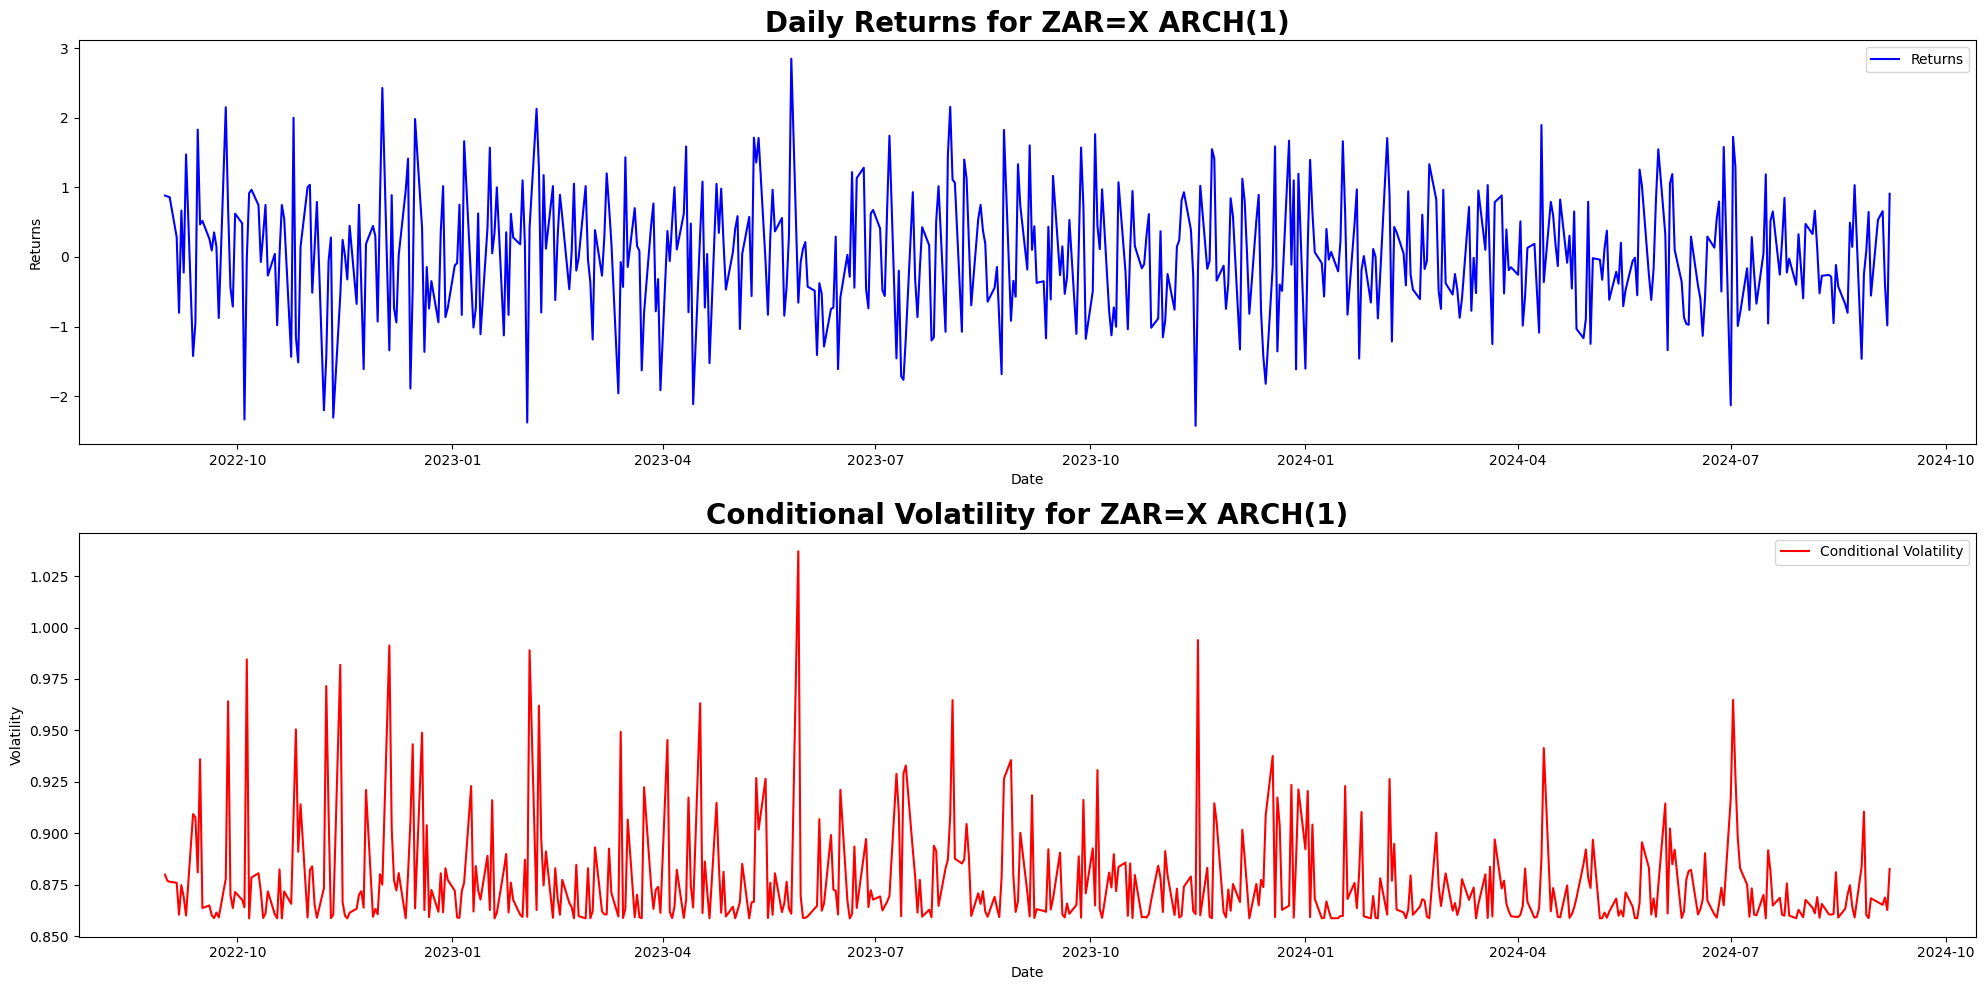

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -676.275
Distribution:                  Normal   AIC:                           1360.55
Method:            Maximum Likelihood   BIC:                           1377.63
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0111  3.79

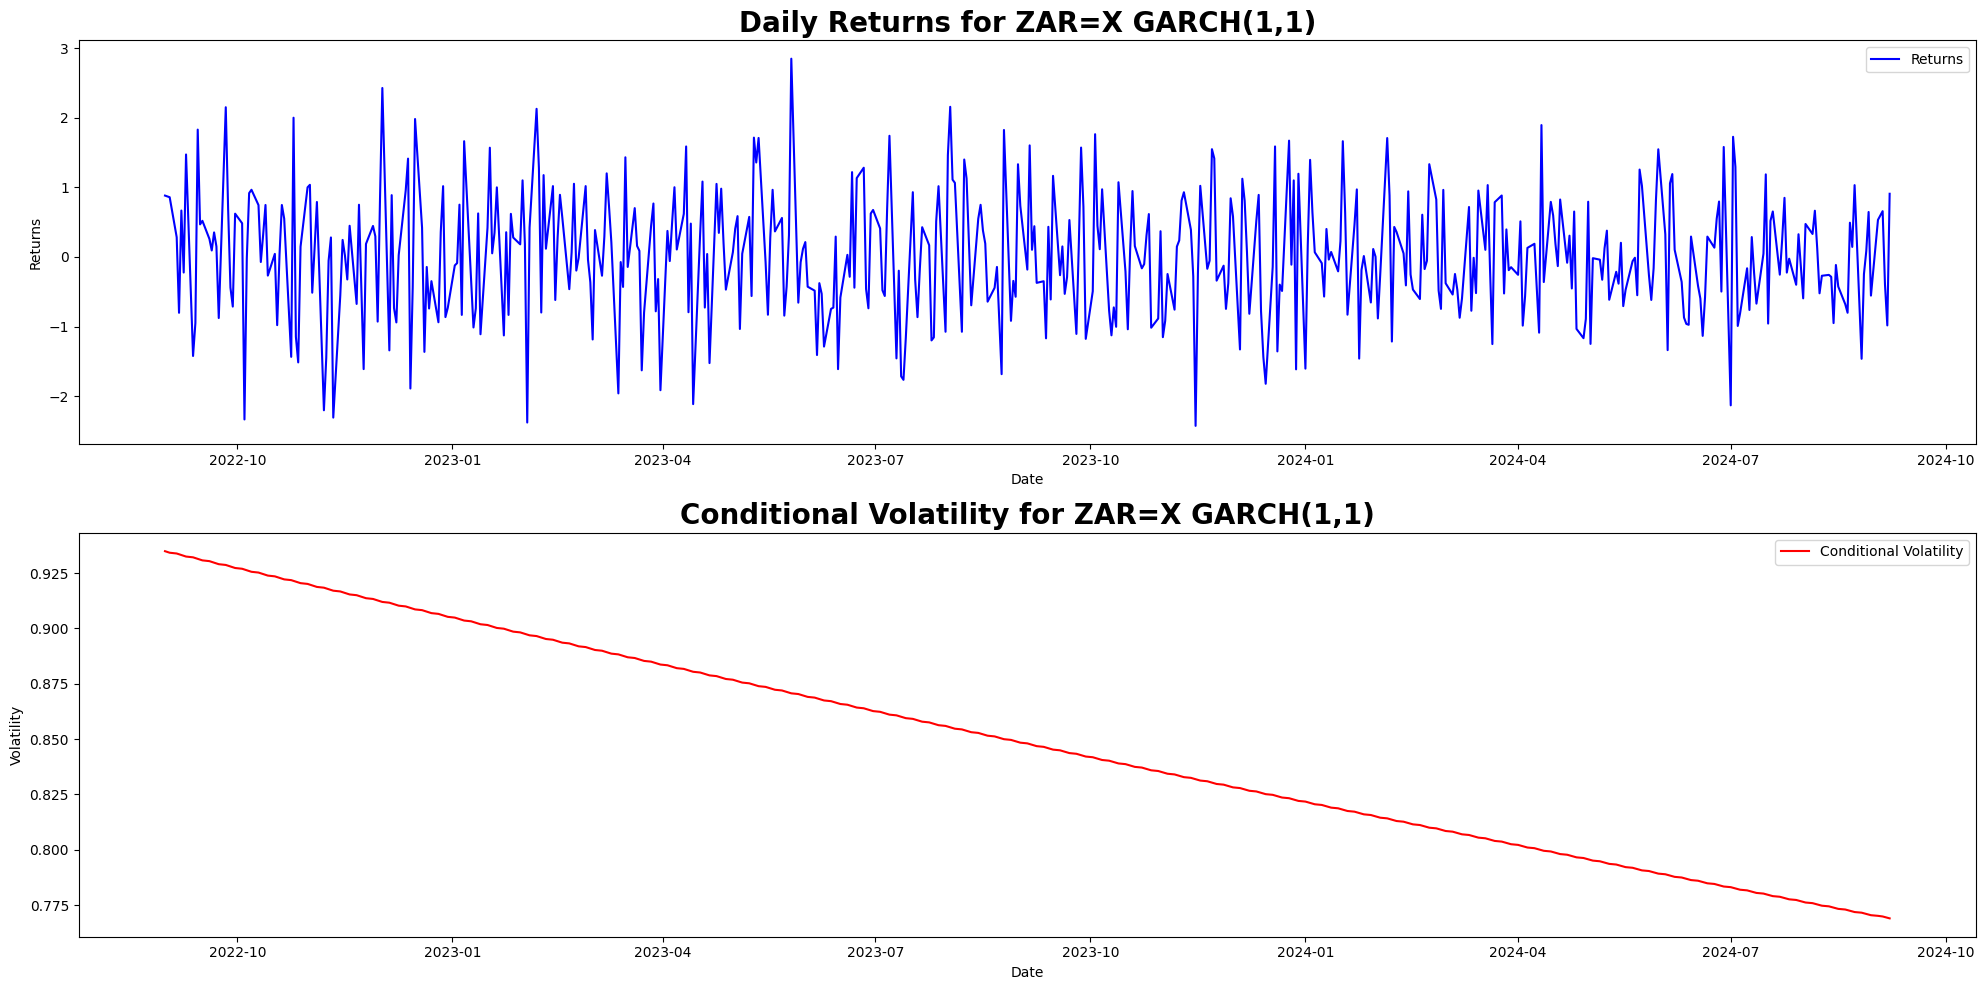

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -670.801
Distribution:                  Normal   AIC:                           1349.60
Method:            Maximum Likelihood   BIC:                           1366.68
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:40   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0149  1.210e

c:\Users\Alli Ajagbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


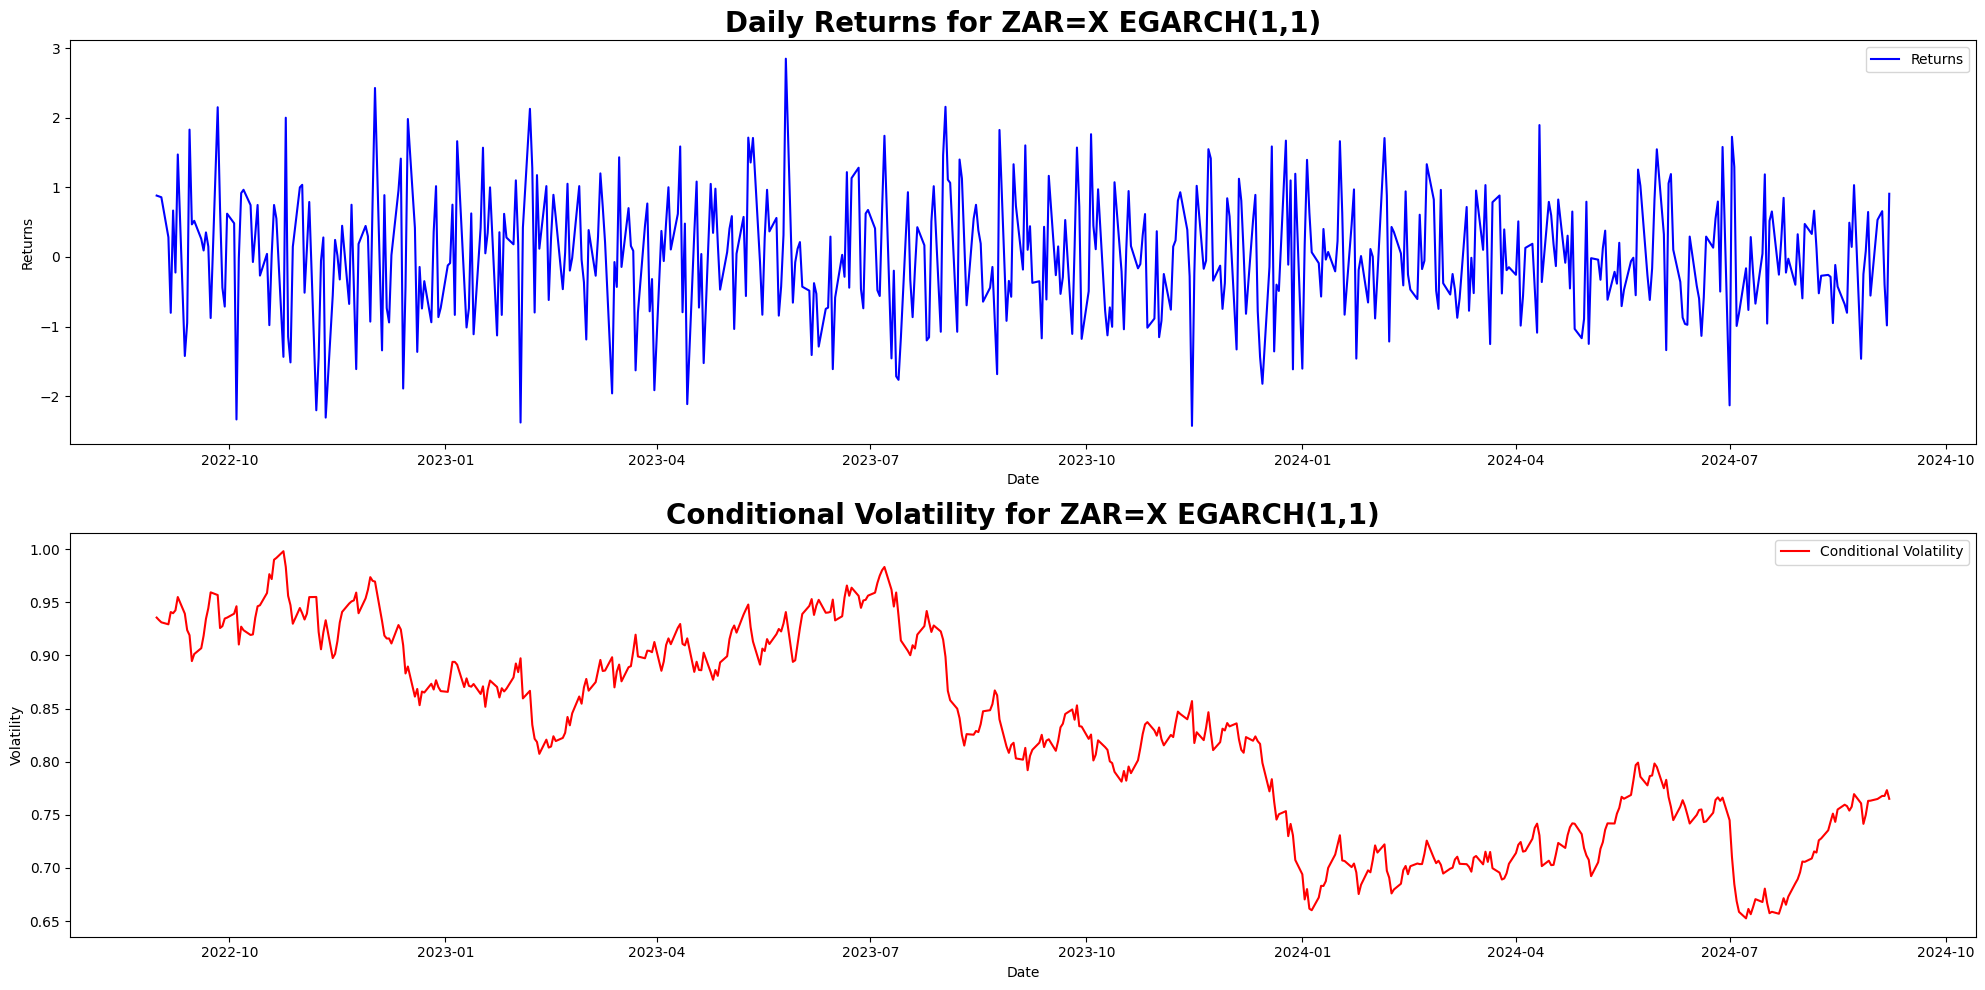

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -676.178
Distribution:                  Normal   AIC:                           1362.36
Method:            Maximum Likelihood   BIC:                           1383.70
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:40   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.0180e-03  4.2

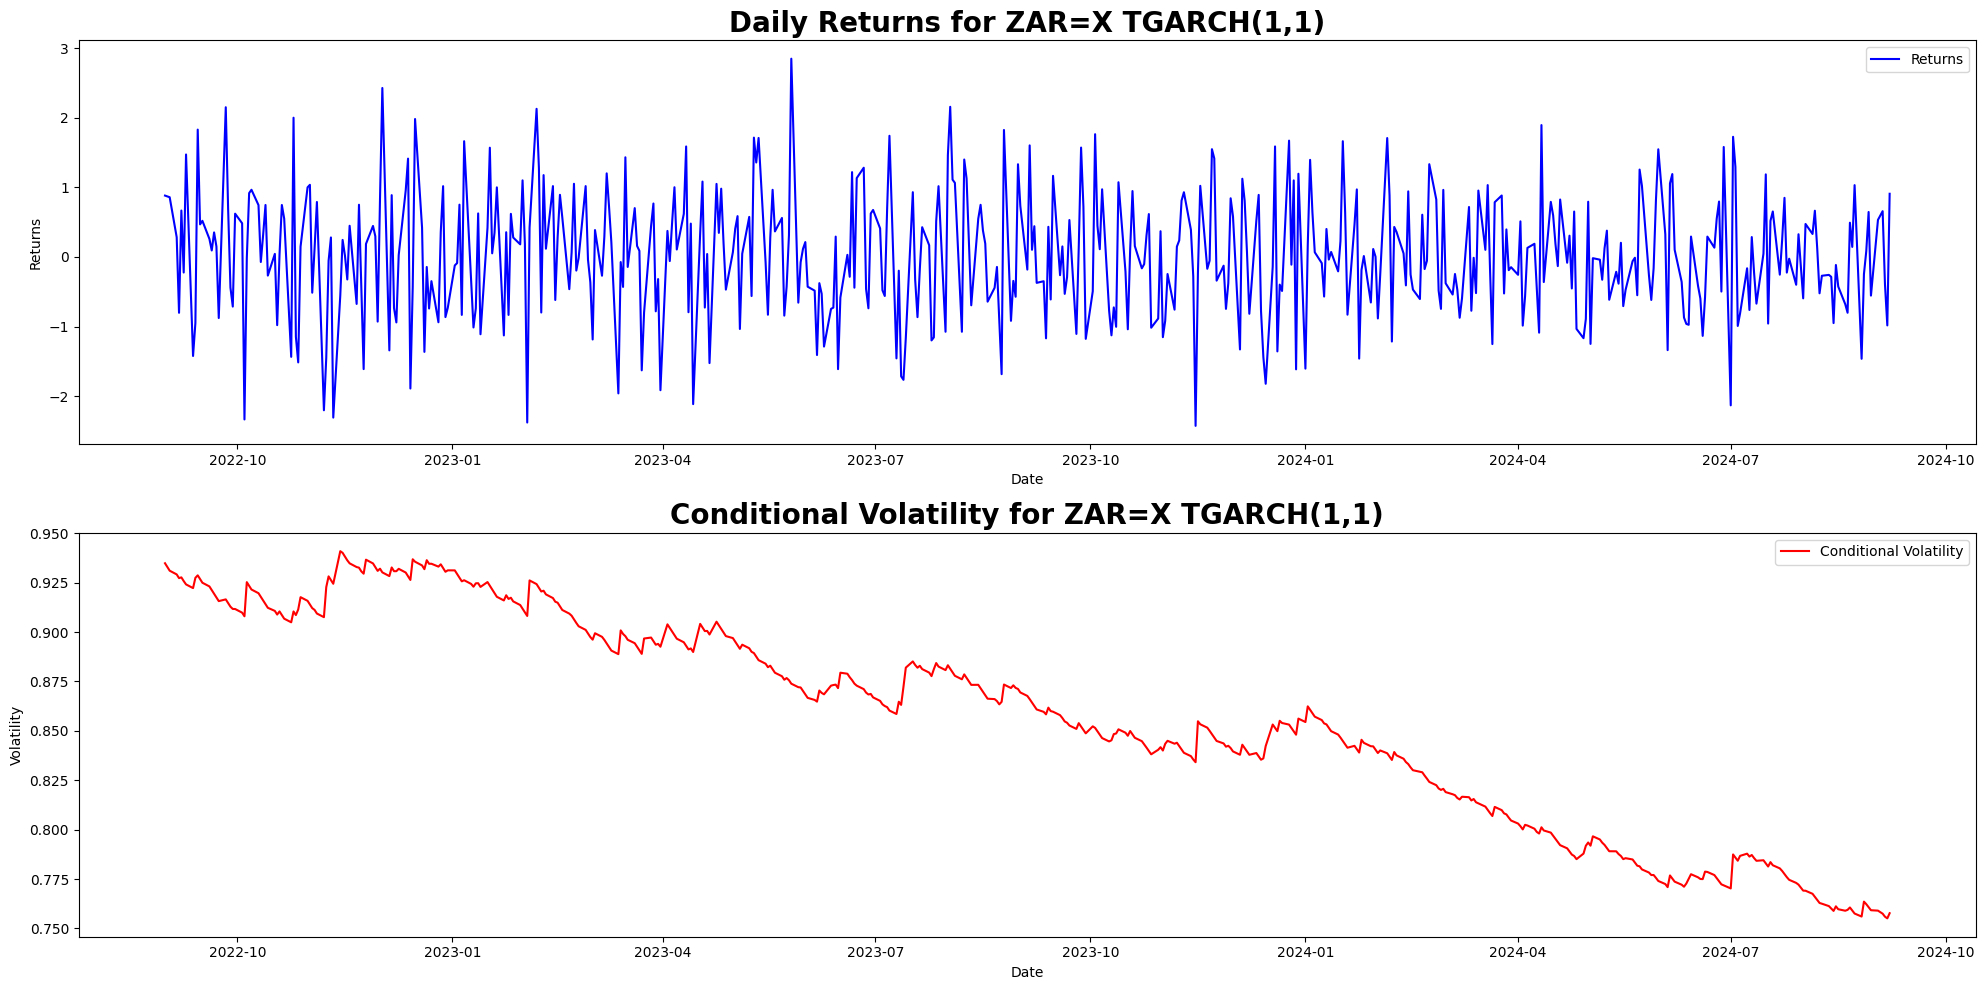

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -678.950
Distribution:                  Normal   AIC:                           1367.90
Method:            Maximum Likelihood   BIC:                           1389.25
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:41   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0138  3.8

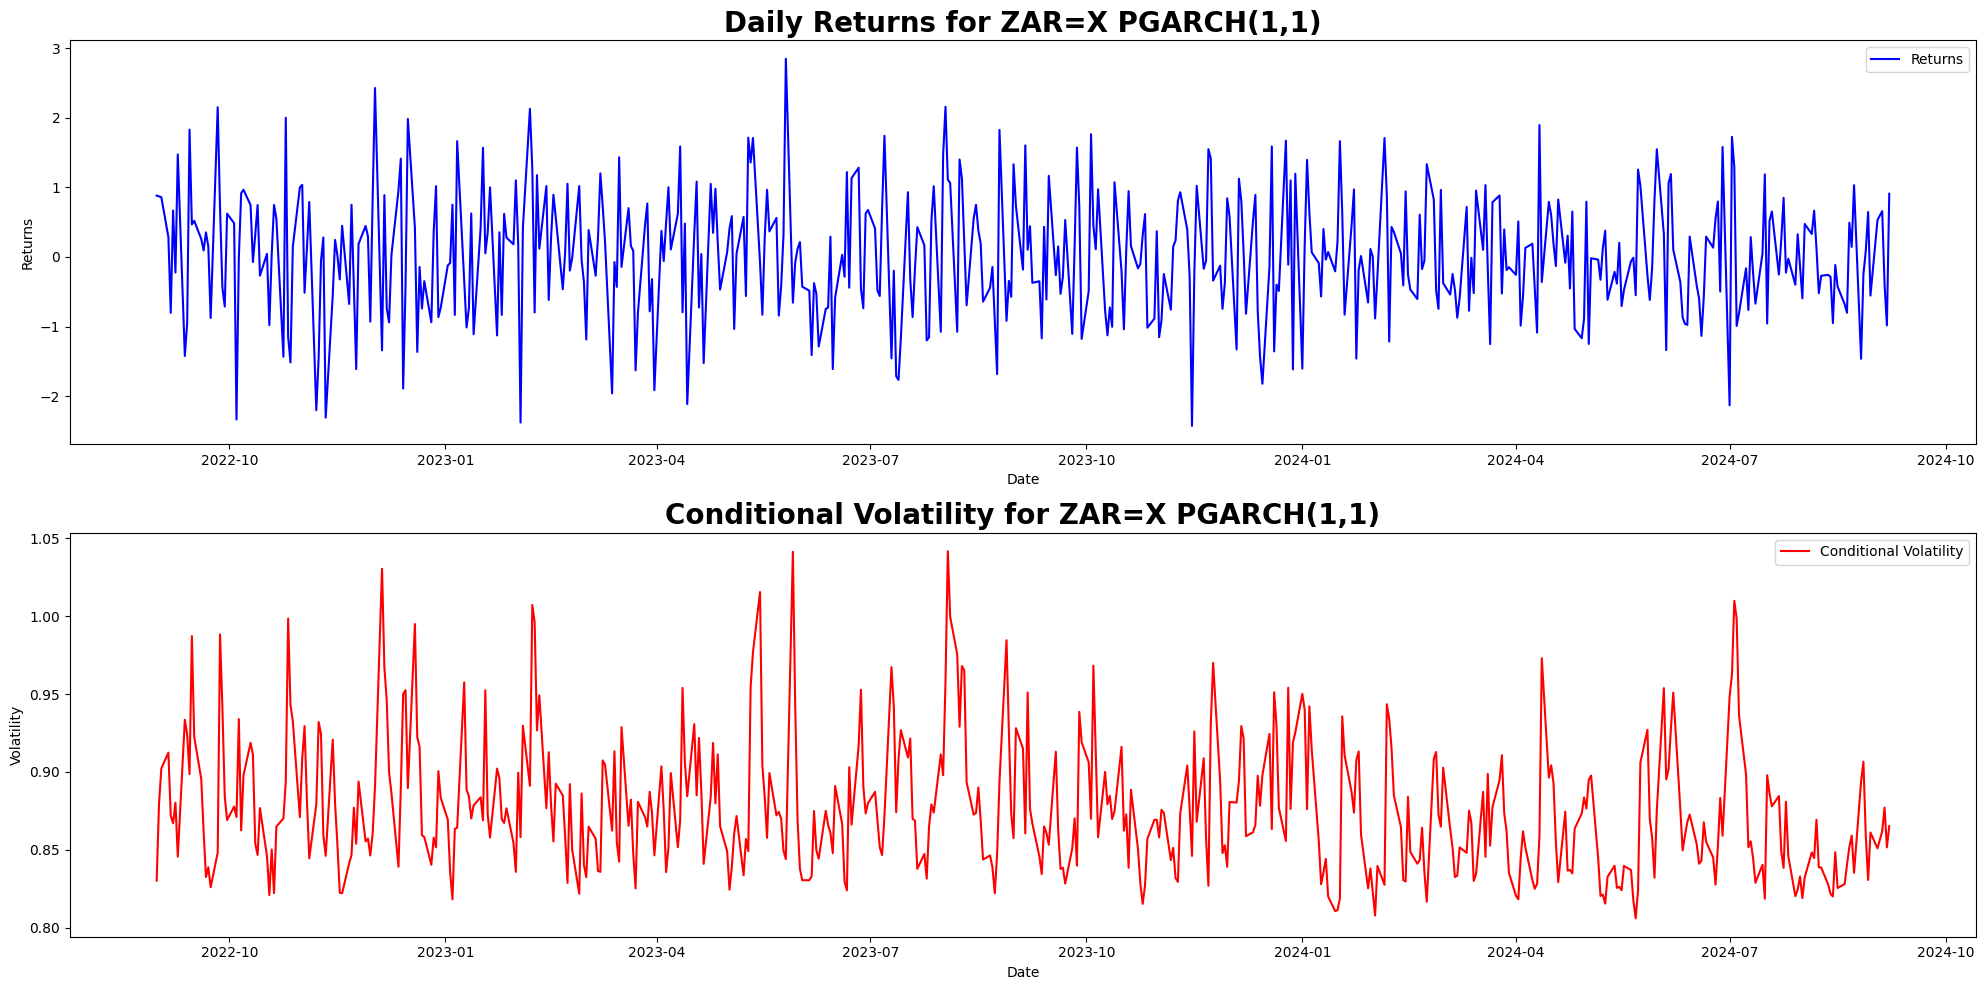


Model Comparisons:
ARCH AIC: 1365.4739414081632, BIC: 1378.281230259282
GARCH AIC: 1360.5508589318451, BIC: 1377.6272440666703
EGARCH AIC: 1349.6025407396355, BIC: 1366.6789258744607
TGARCH AIC: 1362.3556485727302, BIC: 1383.7011299912615
PGARCH AIC: 1367.9000905762286, BIC: 1389.24557199476

Best model based on BIC: EGARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 1.1501724653014256
GARCH - Volatility Forecasting MSE: 1.1363881133247706
EGARCH - Volatility Forecasting MSE: 1.1138408425359607
TGARCH - Volatility Forecasting MSE: 1.135994053682568
PGARCH - Volatility Forecasting MSE: 1.1465230503358819

Best model based on volatility forecasting (lowest mse): EGARCH

**********************************************************Processing AUDUSD=X*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                R

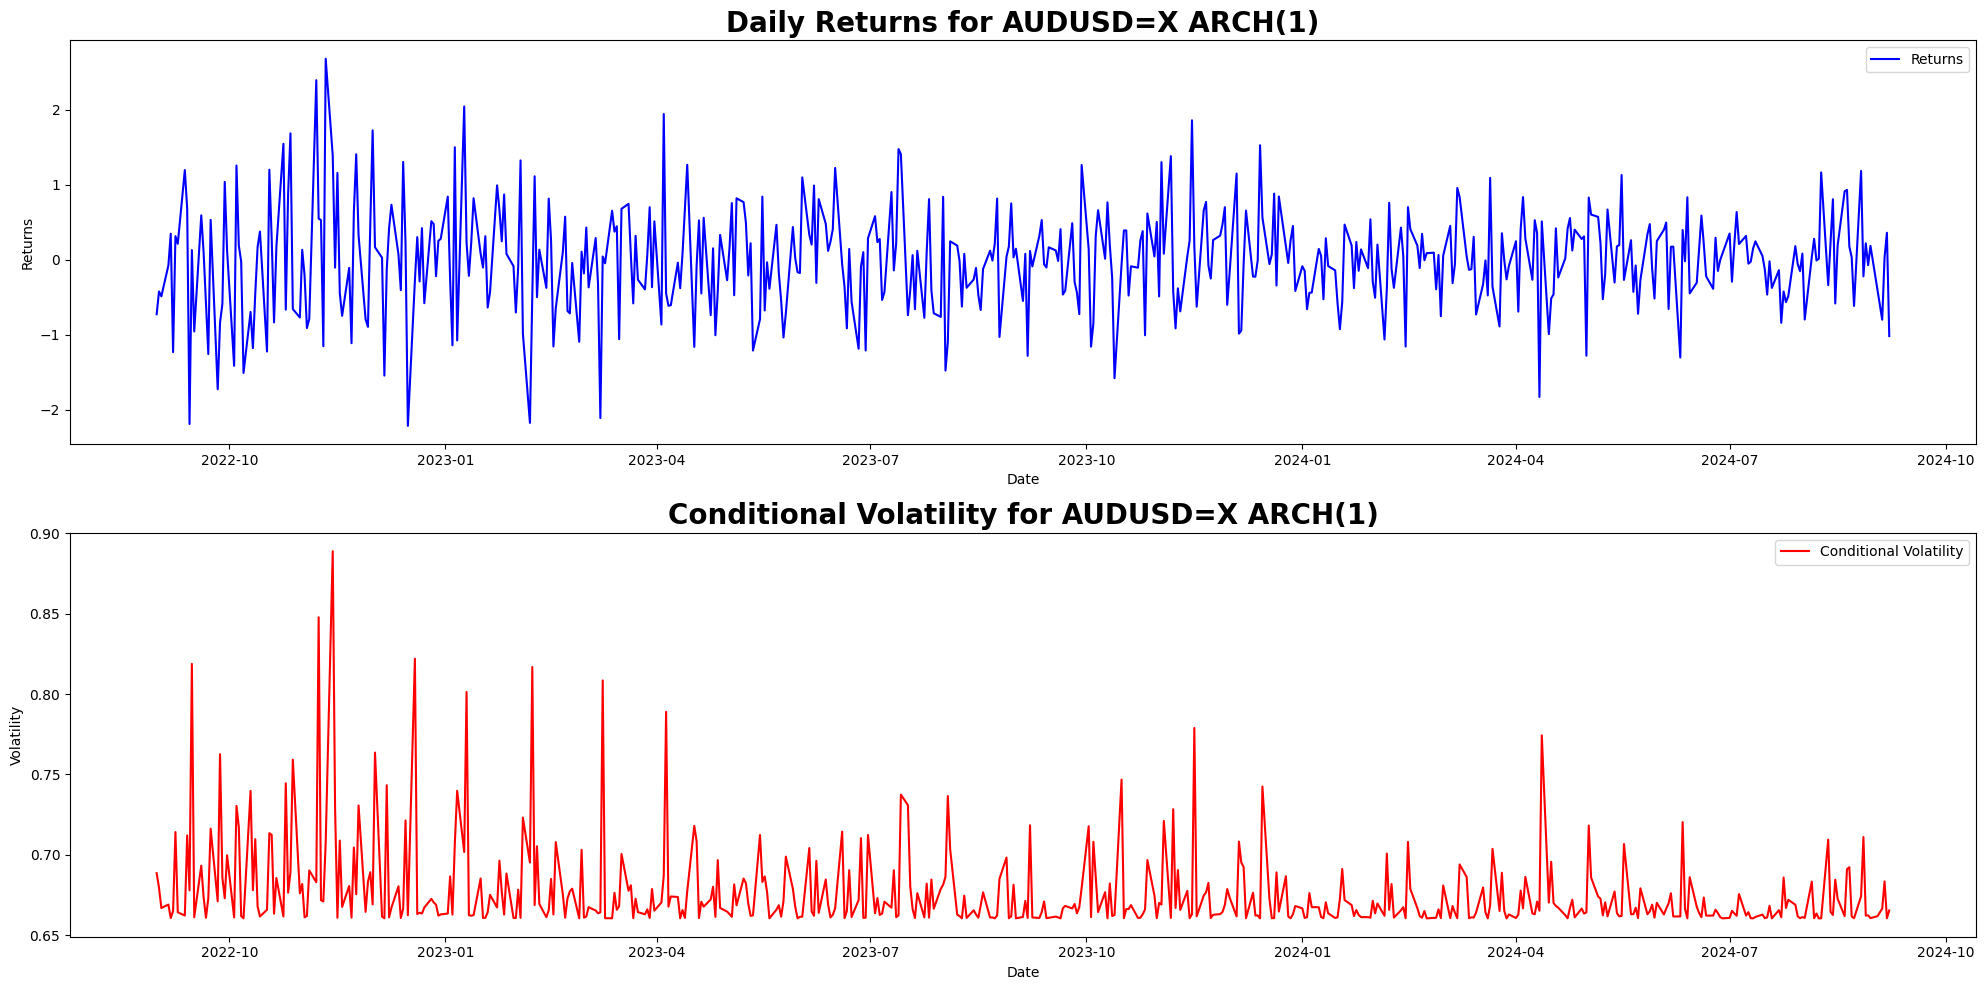

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -518.640
Distribution:                  Normal   AIC:                           1045.28
Method:            Maximum Likelihood   BIC:                           1062.36
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:42   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.1500e-04  2.70

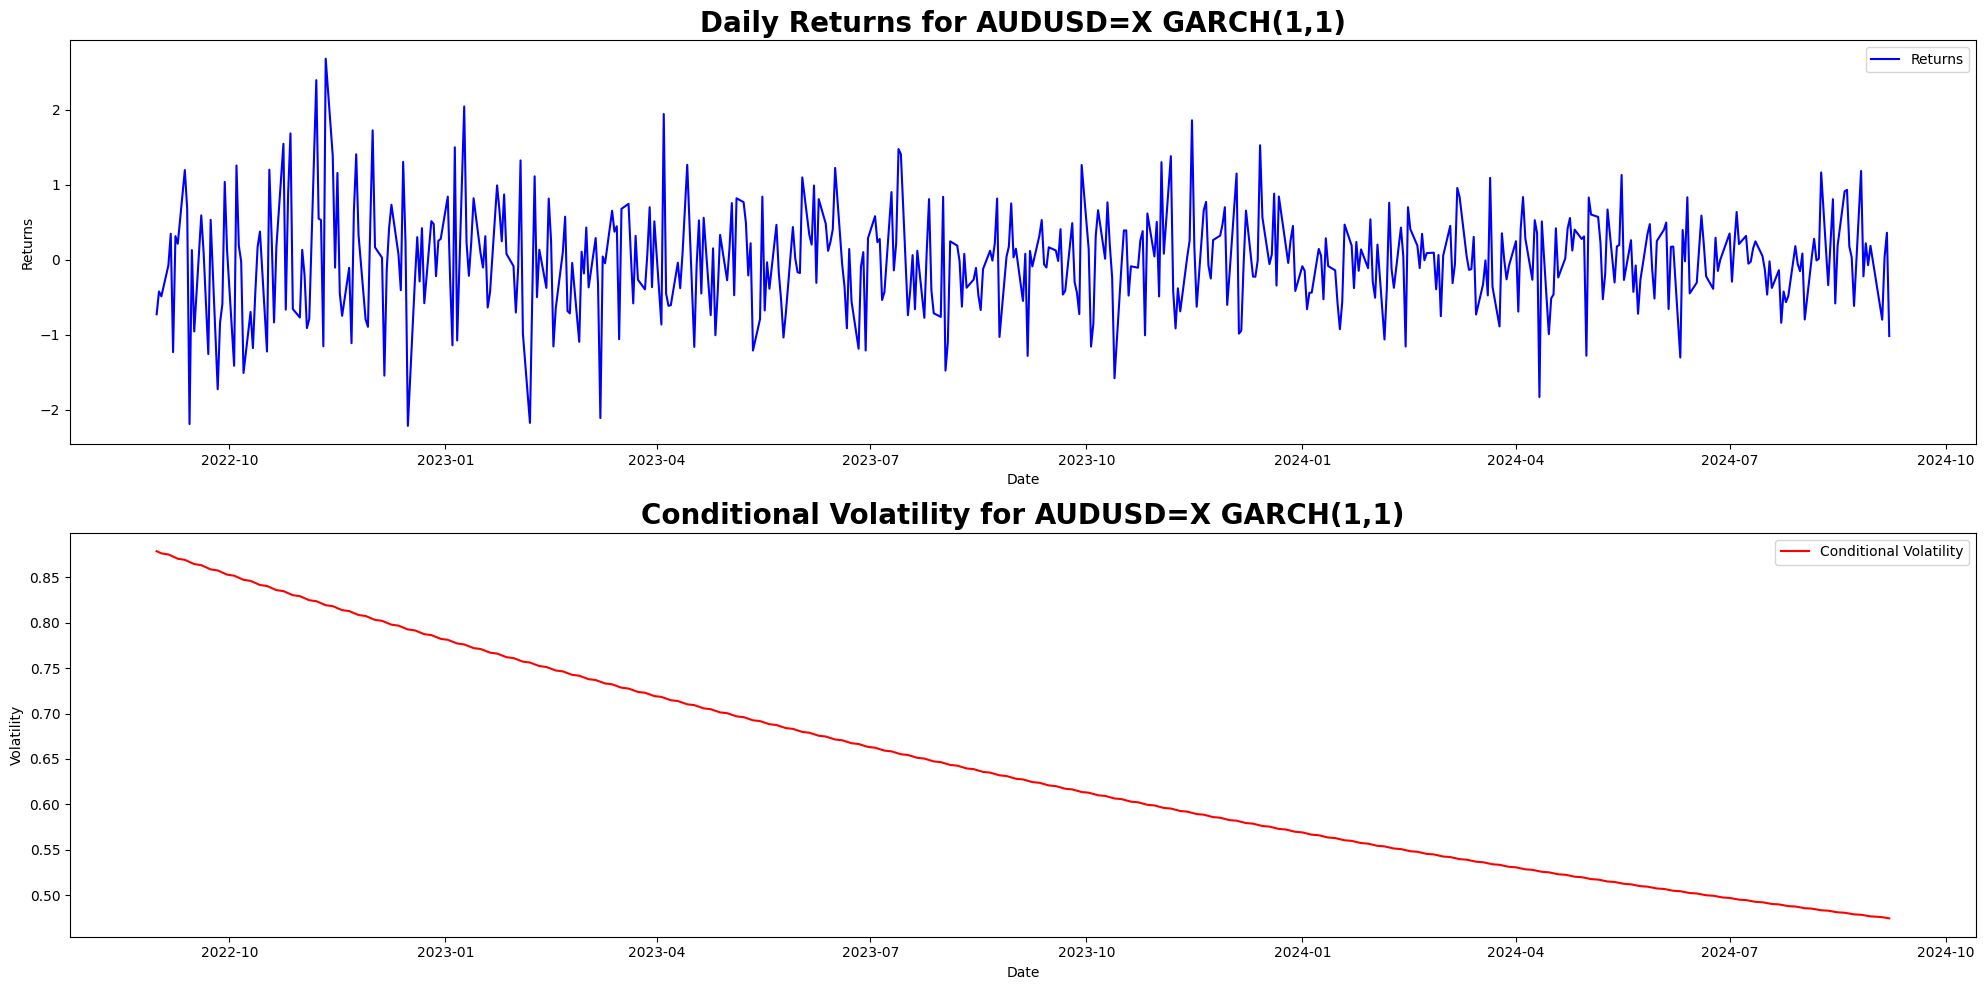

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -516.859
Distribution:                  Normal   AIC:                           1041.72
Method:            Maximum Likelihood   BIC:                           1058.79
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:43   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.7269e-03 

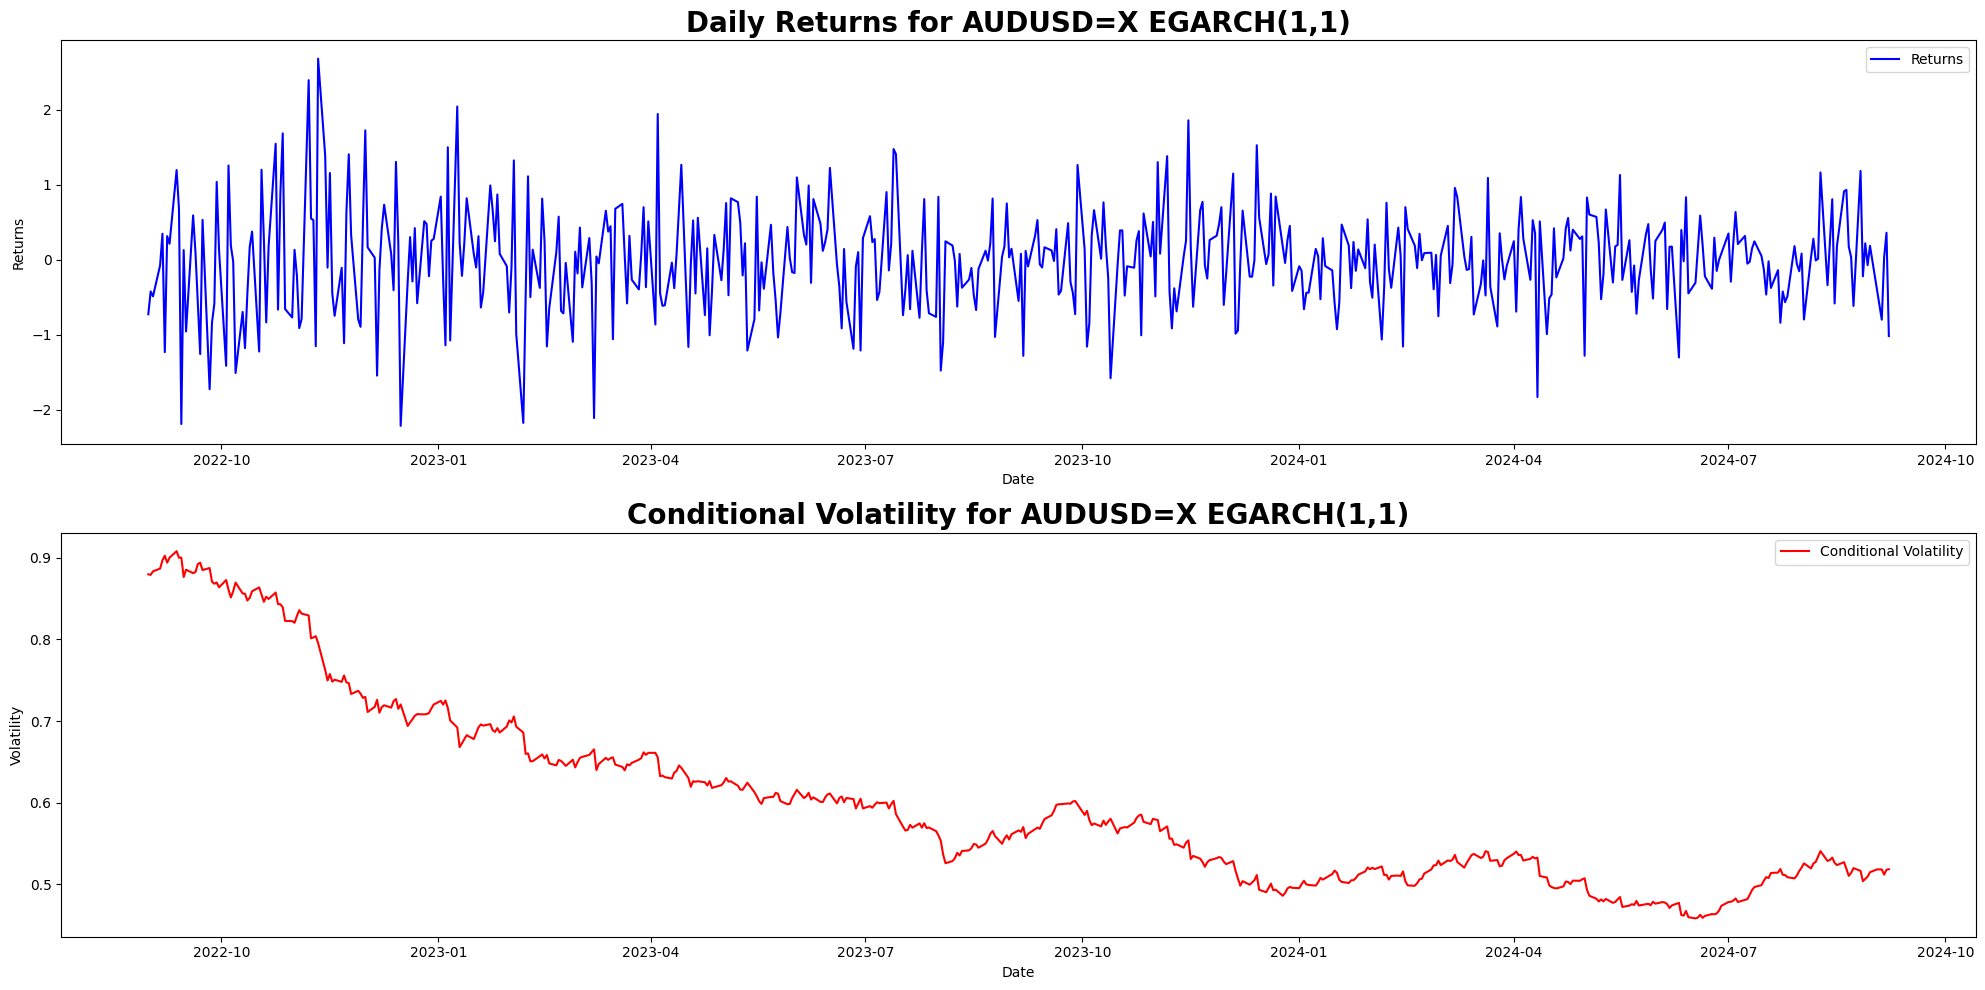

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -518.640
Distribution:                  Normal   AIC:                           1047.28
Method:            Maximum Likelihood   BIC:                           1068.63
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:43   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.1404e-04  2.7

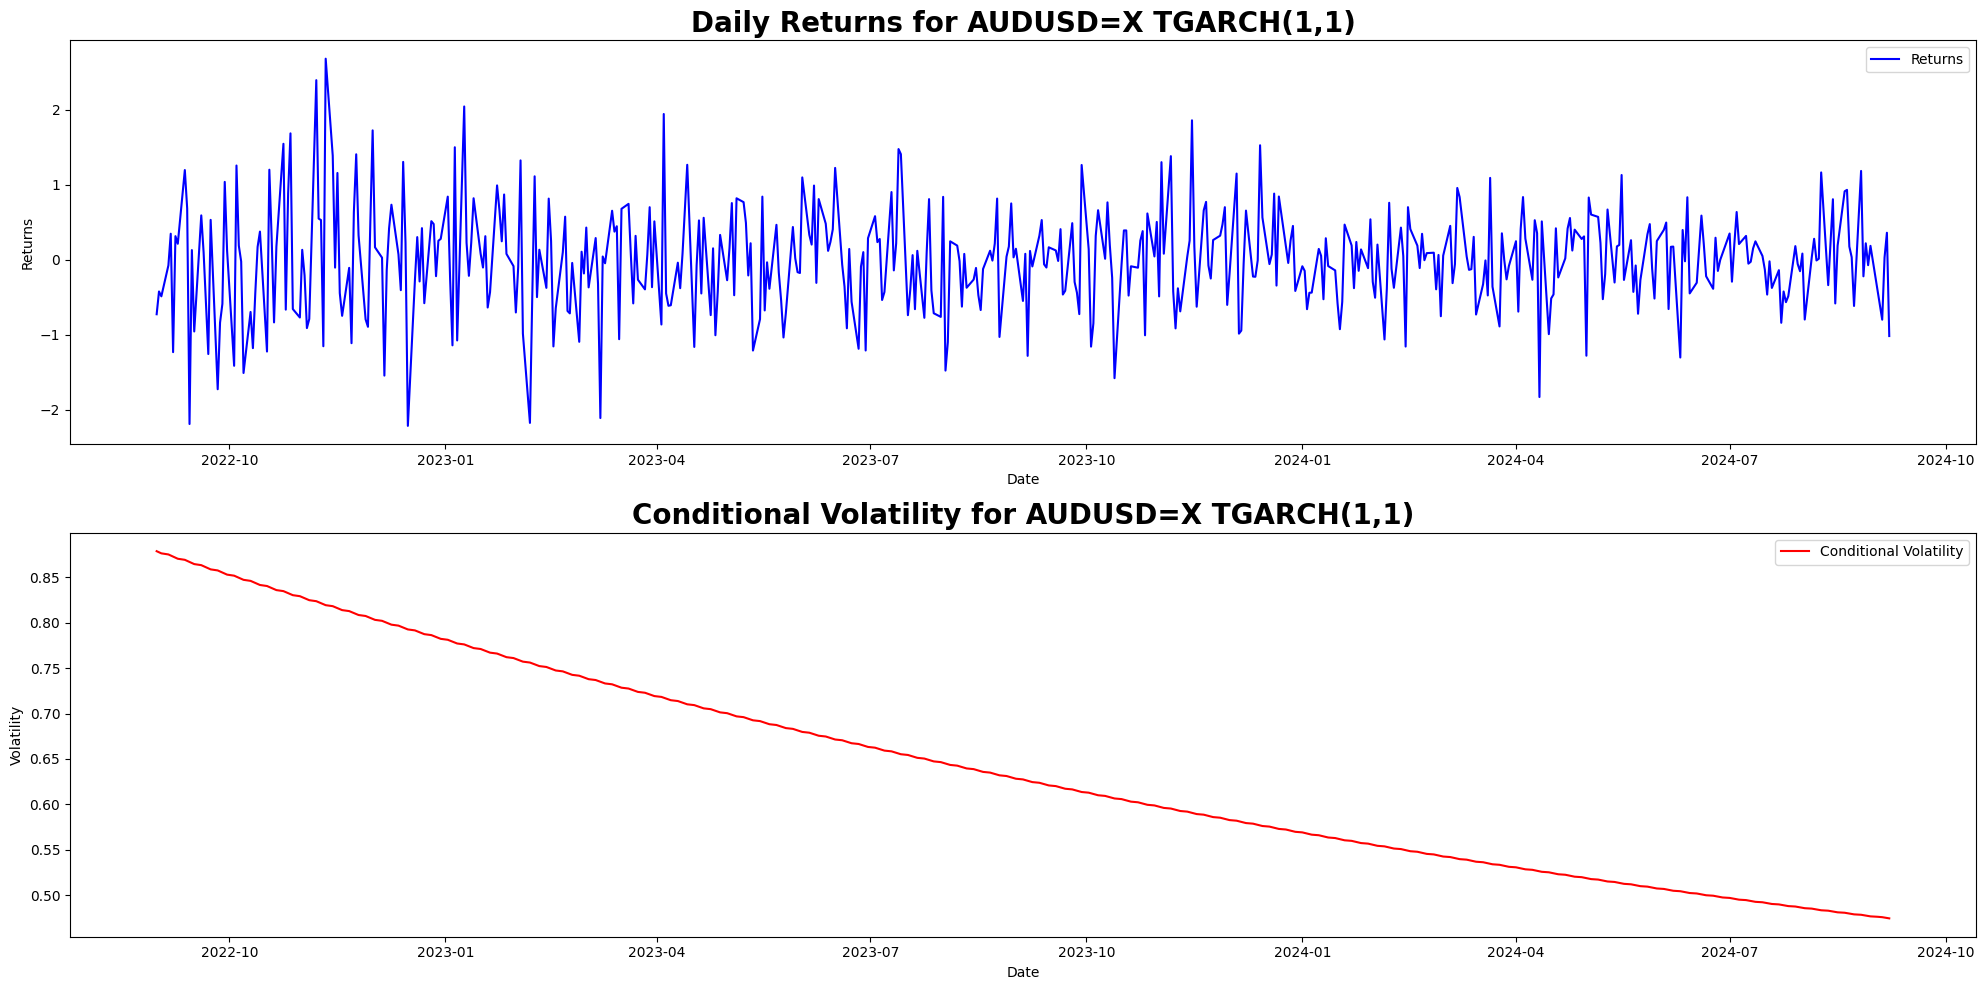

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -522.817
Distribution:                  Normal   AIC:                           1055.63
Method:            Maximum Likelihood   BIC:                           1076.98
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:44   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0120  2.7

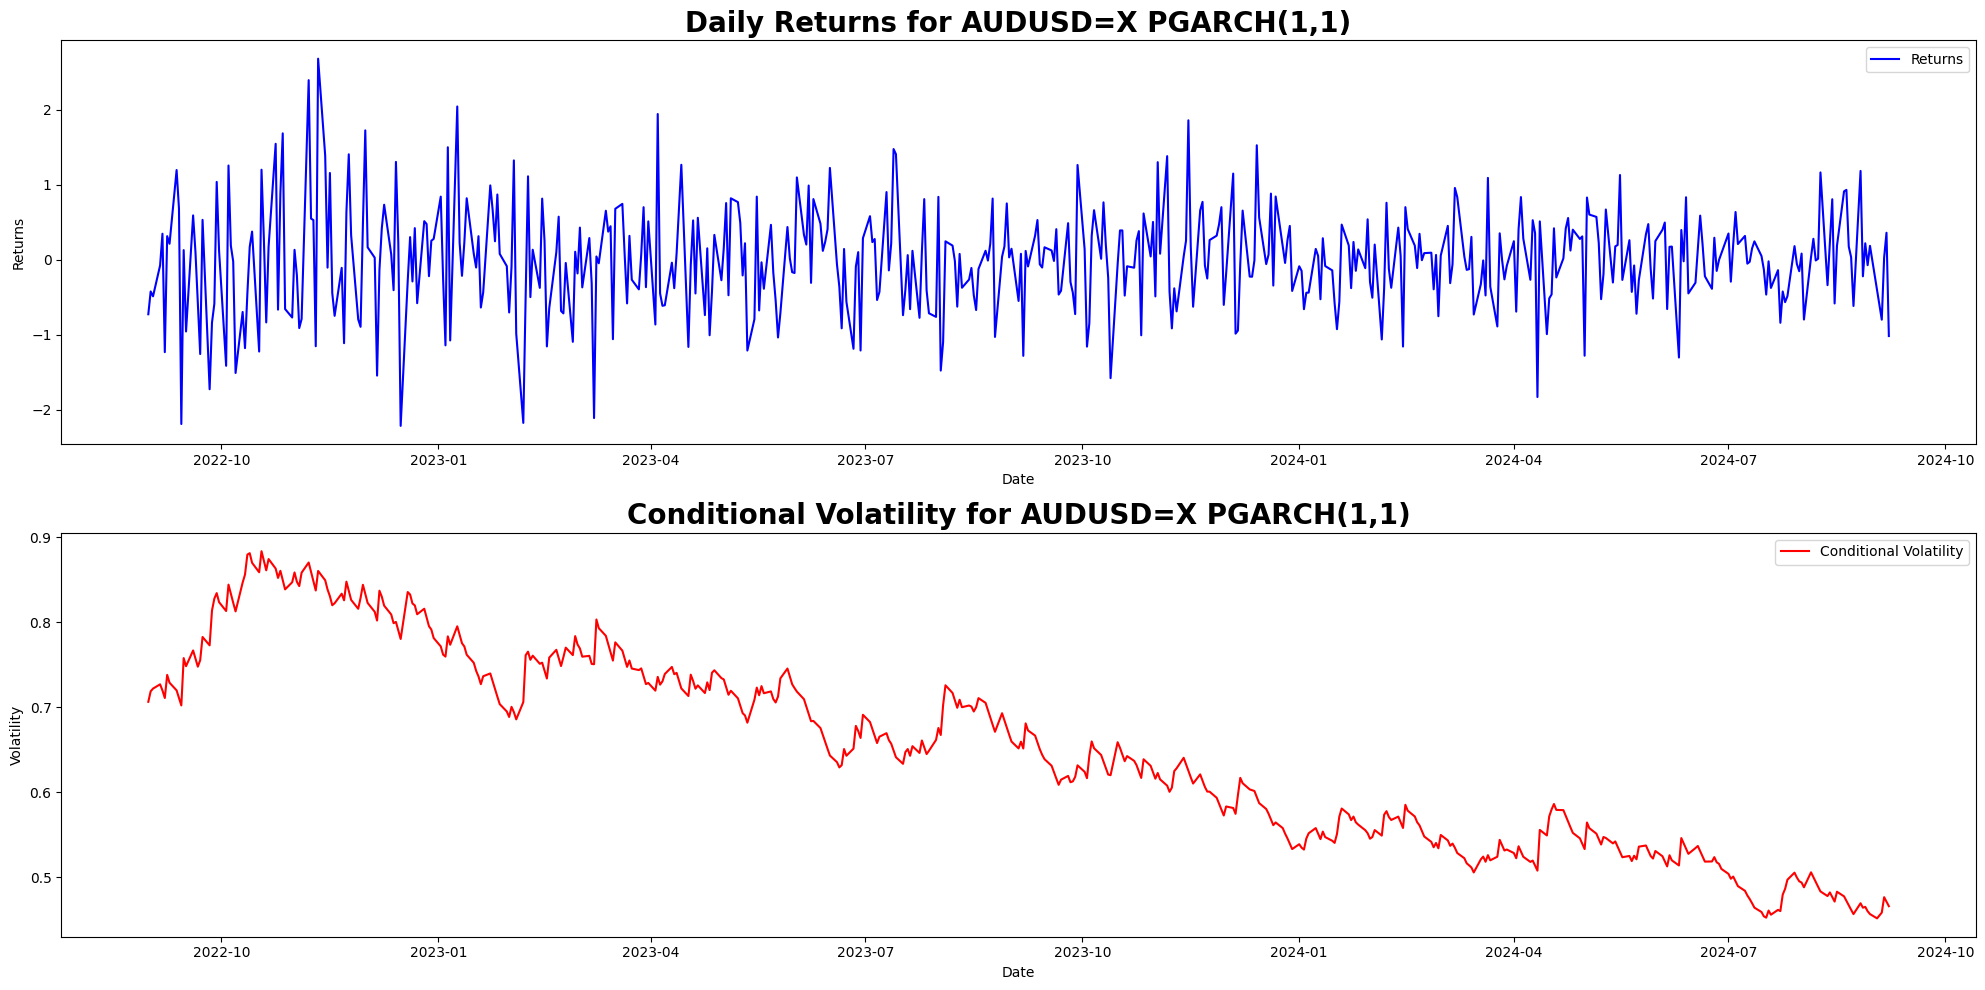


Model Comparisons:
ARCH AIC: 1091.2878891517414, BIC: 1104.0951780028602
GARCH AIC: 1045.2798563631154, BIC: 1062.3562414979406
EGARCH AIC: 1041.7182170275305, BIC: 1058.7946021623557
TGARCH AIC: 1047.2798566243118, BIC: 1068.6253380428432
PGARCH AIC: 1055.6334493925367, BIC: 1076.978930811068

Best model based on BIC: EGARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 0.6419641481631231
GARCH - Volatility Forecasting MSE: 0.6012366262752905
EGARCH - Volatility Forecasting MSE: 0.6013808781523678
TGARCH - Volatility Forecasting MSE: 0.6012364888996955
PGARCH - Volatility Forecasting MSE: 0.6077889091498082

Best model based on volatility forecasting (lowest mse): TGARCH

**********************************************************Processing GBPUSD=X*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              

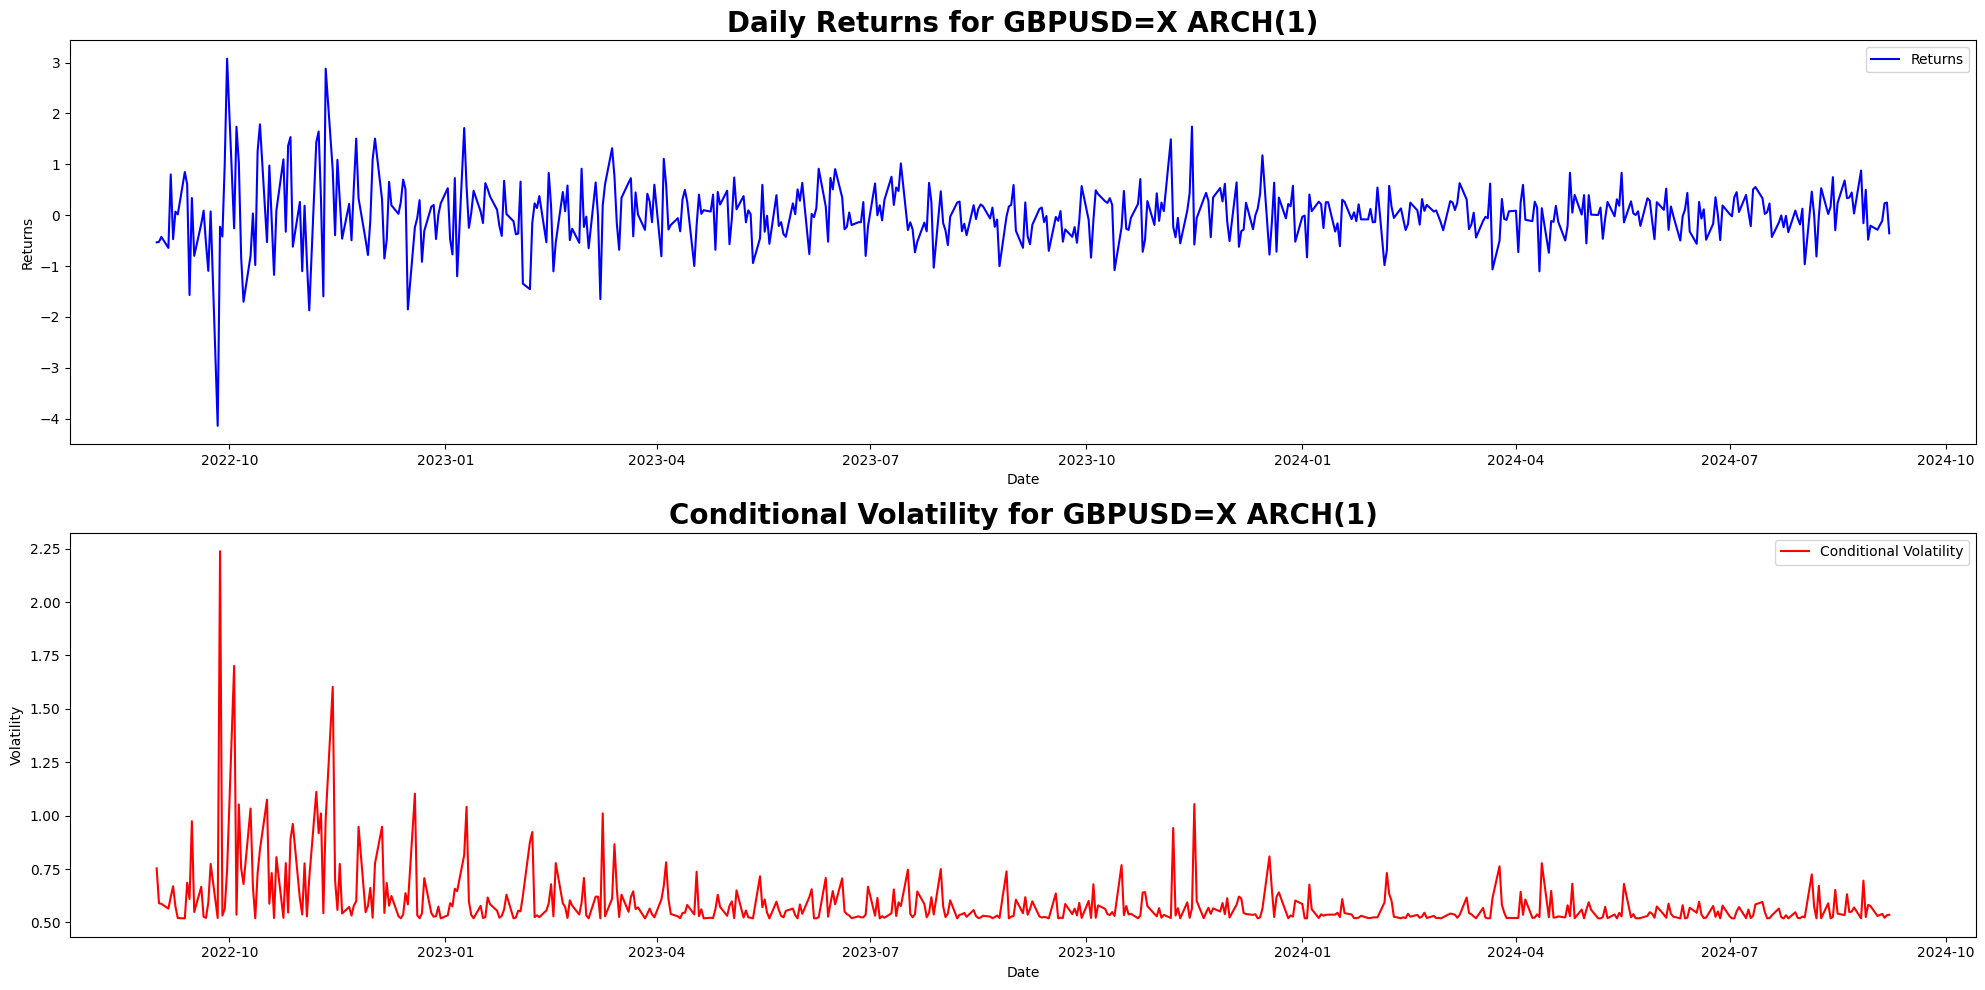

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -396.226
Distribution:                  Normal   AIC:                           800.452
Method:            Maximum Likelihood   BIC:                           817.528
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:45   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0213  2.03

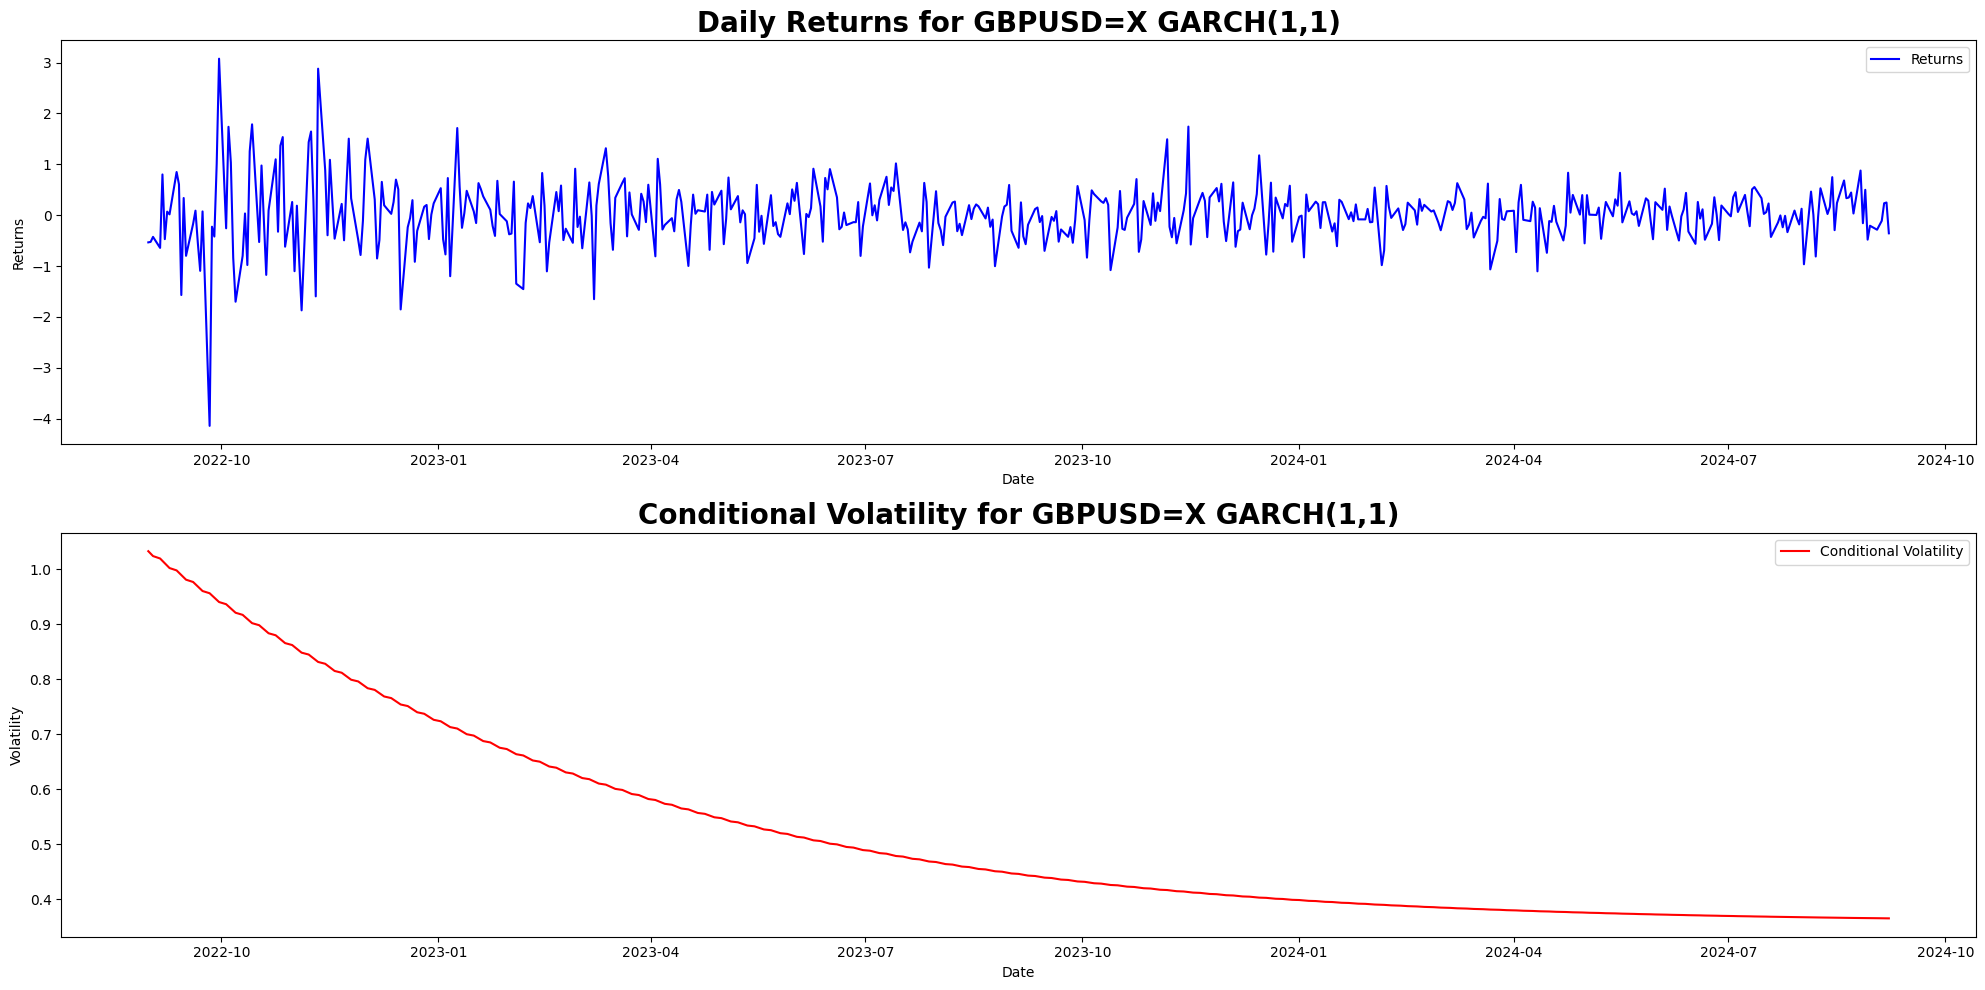

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -387.853
Distribution:                  Normal   AIC:                           783.705
Method:            Maximum Likelihood   BIC:                           800.782
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0124  9.678e

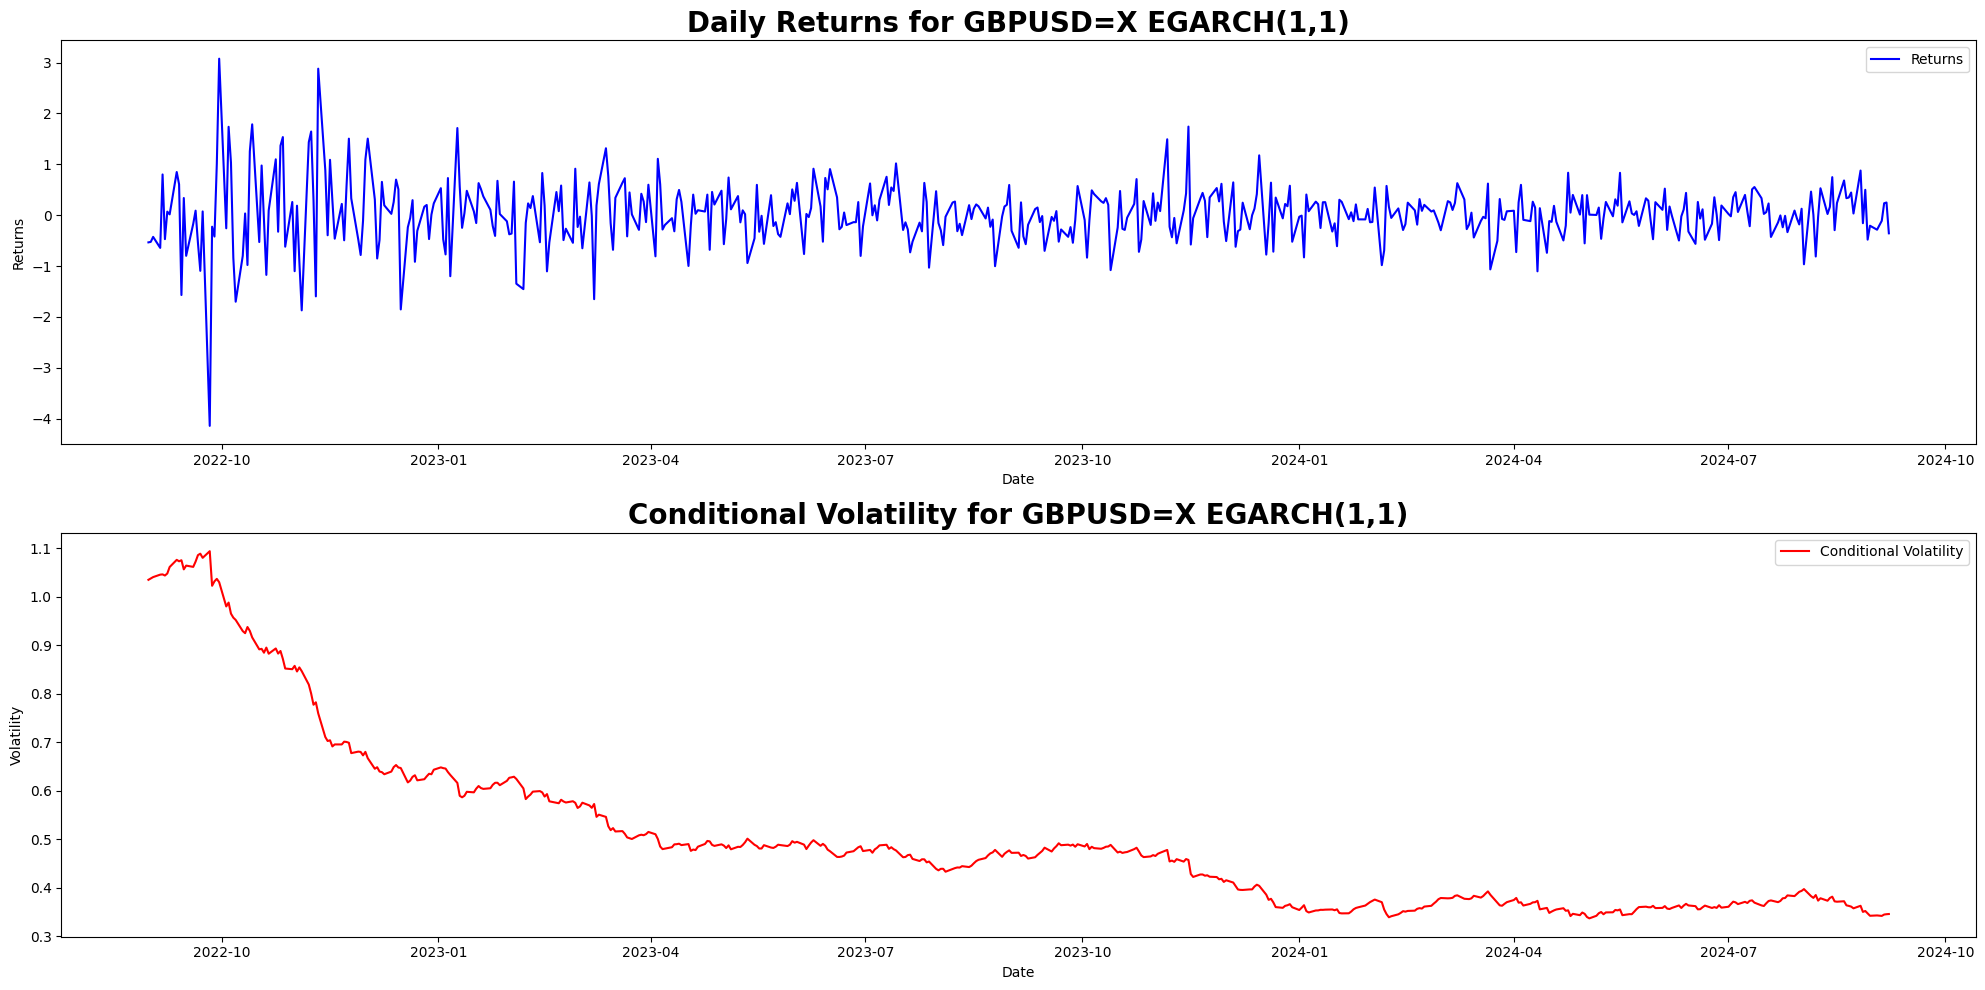

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -395.415
Distribution:                  Normal   AIC:                           800.830
Method:            Maximum Likelihood   BIC:                           822.175
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:46   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0164  2.0

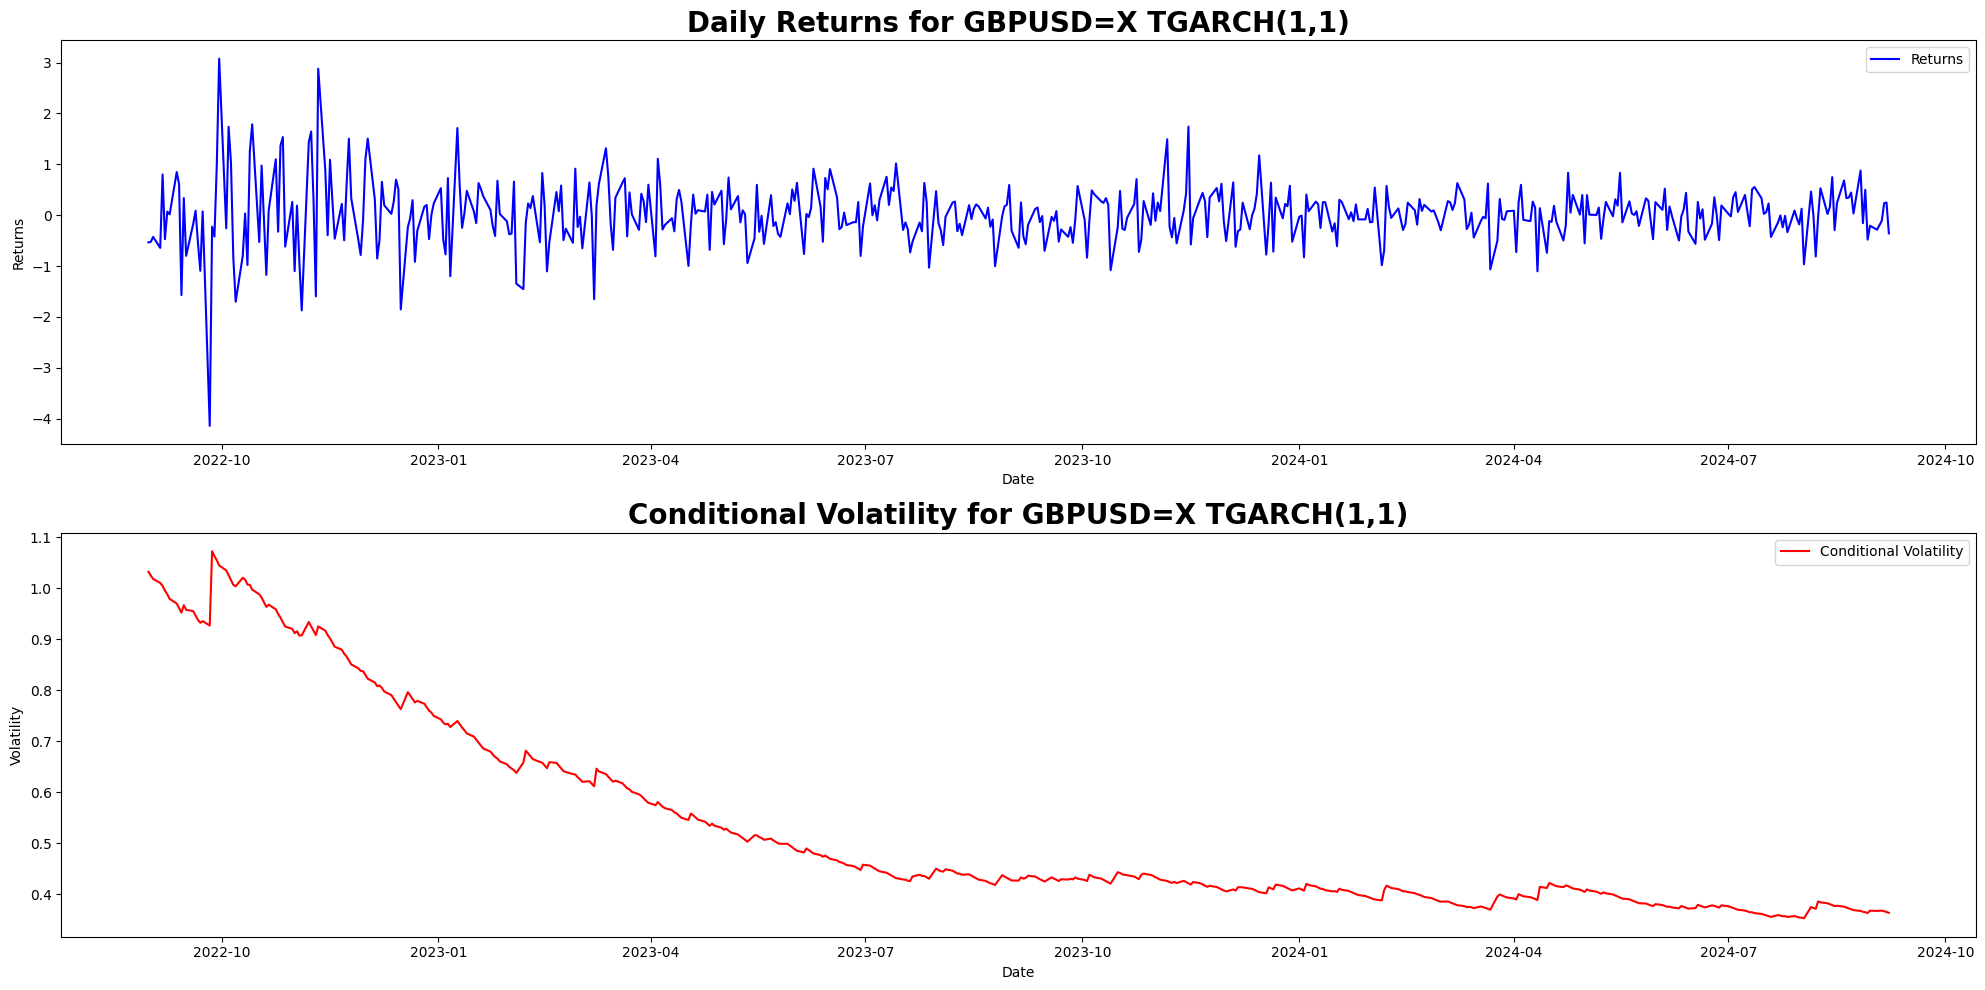

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -401.060
Distribution:                  Normal   AIC:                           812.120
Method:            Maximum Likelihood   BIC:                           833.465
                                        No. Observations:                  528
Date:                Sat, Sep 07 2024   Df Residuals:                      527
Time:                        20:05:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.5323e-03  2.1

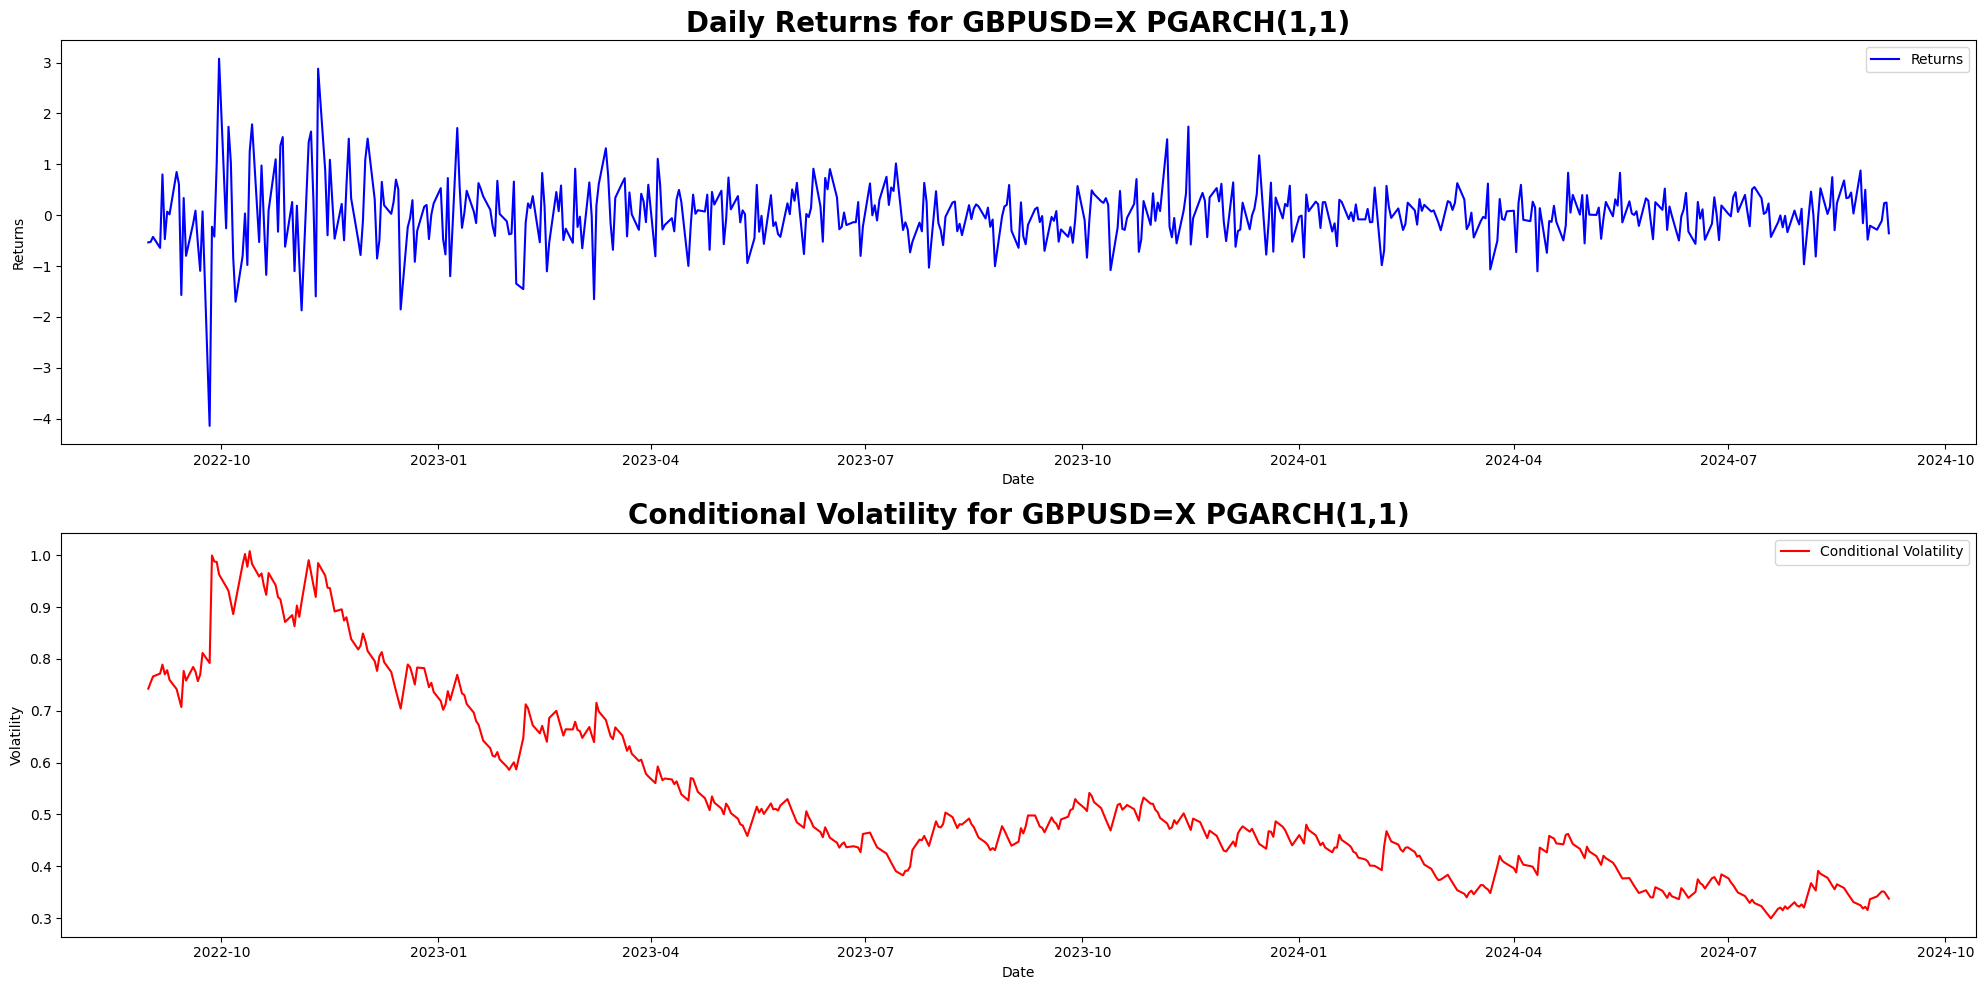


Model Comparisons:
ARCH AIC: 929.63885887227, BIC: 942.4461477233888
GARCH AIC: 800.4518750673487, BIC: 817.5282602021738
EGARCH AIC: 783.7052696374003, BIC: 800.7816547722254
TGARCH AIC: 800.8297879626749, BIC: 822.1752693812062
PGARCH AIC: 812.1196711901466, BIC: 833.465152608678

Best model based on BIC: EGARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 1.1437886905815706
GARCH - Volatility Forecasting MSE: 1.0010917673953181
EGARCH - Volatility Forecasting MSE: 0.9842808459673964
TGARCH - Volatility Forecasting MSE: 0.9898297338822423
PGARCH - Volatility Forecasting MSE: 0.9995394824228735

Best model based on volatility forecasting (lowest mse): EGARCH


In [74]:
for key, df in exchange_data.items():
    returns = calculate_returns(df)
    evaluate_and_visualize_models(returns, key)

The results show that for USD/ZAR and GBP/USD, EGARCH was the best model based on both the Bayesian Information Criterion (BIC) and volatility forecasting. This suggests that these currency pairs exhibit strong asymmetric volatility, where negative shocks, such as bad news, have a greater impact on volatility than positive shocks, making EGARCH's ability to capture this leverage effect particularly effective for both model selection and volatility prediction. For AUD/USD, while EGARCH was the best model according to BIC, TGARCH performed better in volatility forecasting. This indicates that while EGARCH captured the overall volatility structure well, TGARCH's handling of threshold effects provided a better forecast of future volatility. This may reflect that in the AUD/USD market, negative shocks have a different but more subtle impact on volatility that TGARCH captures more effectively in short-term forecasting.

# **Question 2**

In [51]:
stock_tickers = ['TCS.NS', 'COALINDIA.NS', 'BAJFINANCE.NS']
stock_data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in stock_tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [52]:
for ticker, data in stock_data.items():
    print(f"Data for {ticker}")
    print(data.head())

Data for TCS.NS
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-08-30  3155.000000  3226.500000  3142.100098  3211.149902  3063.410156   
2022-09-01  3190.000000  3190.000000  3121.000000  3131.699951  2987.615967   
2022-09-02  3163.000000  3163.000000  3120.300049  3130.399902  2986.375732   
2022-09-05  3123.649902  3147.949951  3112.250000  3133.399902  2989.237793   
2022-09-06  3135.500000  3140.850098  3106.350098  3127.050049  2983.179932   

             Volume  
Date                 
2022-08-30  3431525  
2022-09-01  3546935  
2022-09-02  2052900  
2022-09-05  2147912  
2022-09-06  1936453  
Data for COALINDIA.NS
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-08-30  231.800003  235.500000  230.850006  234.800003  198.011673   
2022-09-01  234.350006  236.8000


**********************************************************Processing TCS.NS*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -806.307
Distribution:                  Normal   AIC:                           1618.61
Method:            Maximum Likelihood   BIC:                           1631.24
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:02   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t   

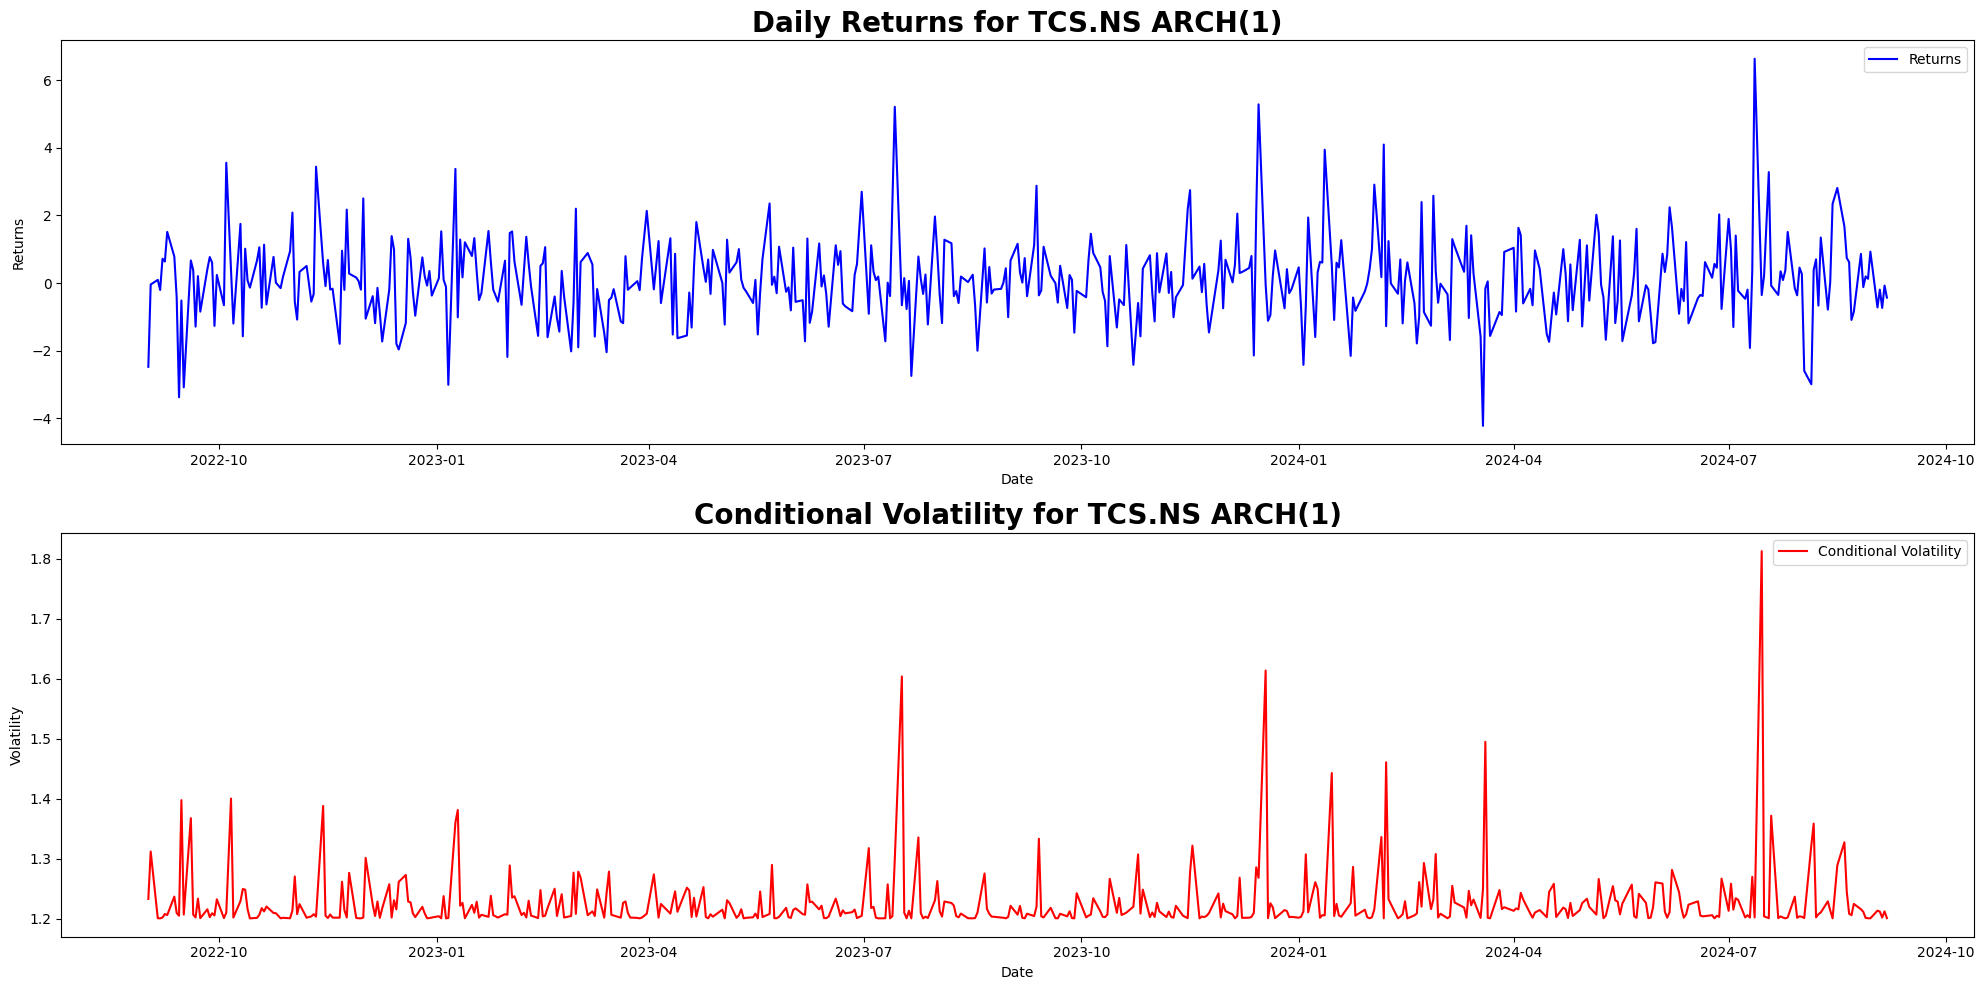

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -806.047
Distribution:                  Normal   AIC:                           1620.09
Method:            Maximum Likelihood   BIC:                           1636.93
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:04   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0814  5.421e-02 

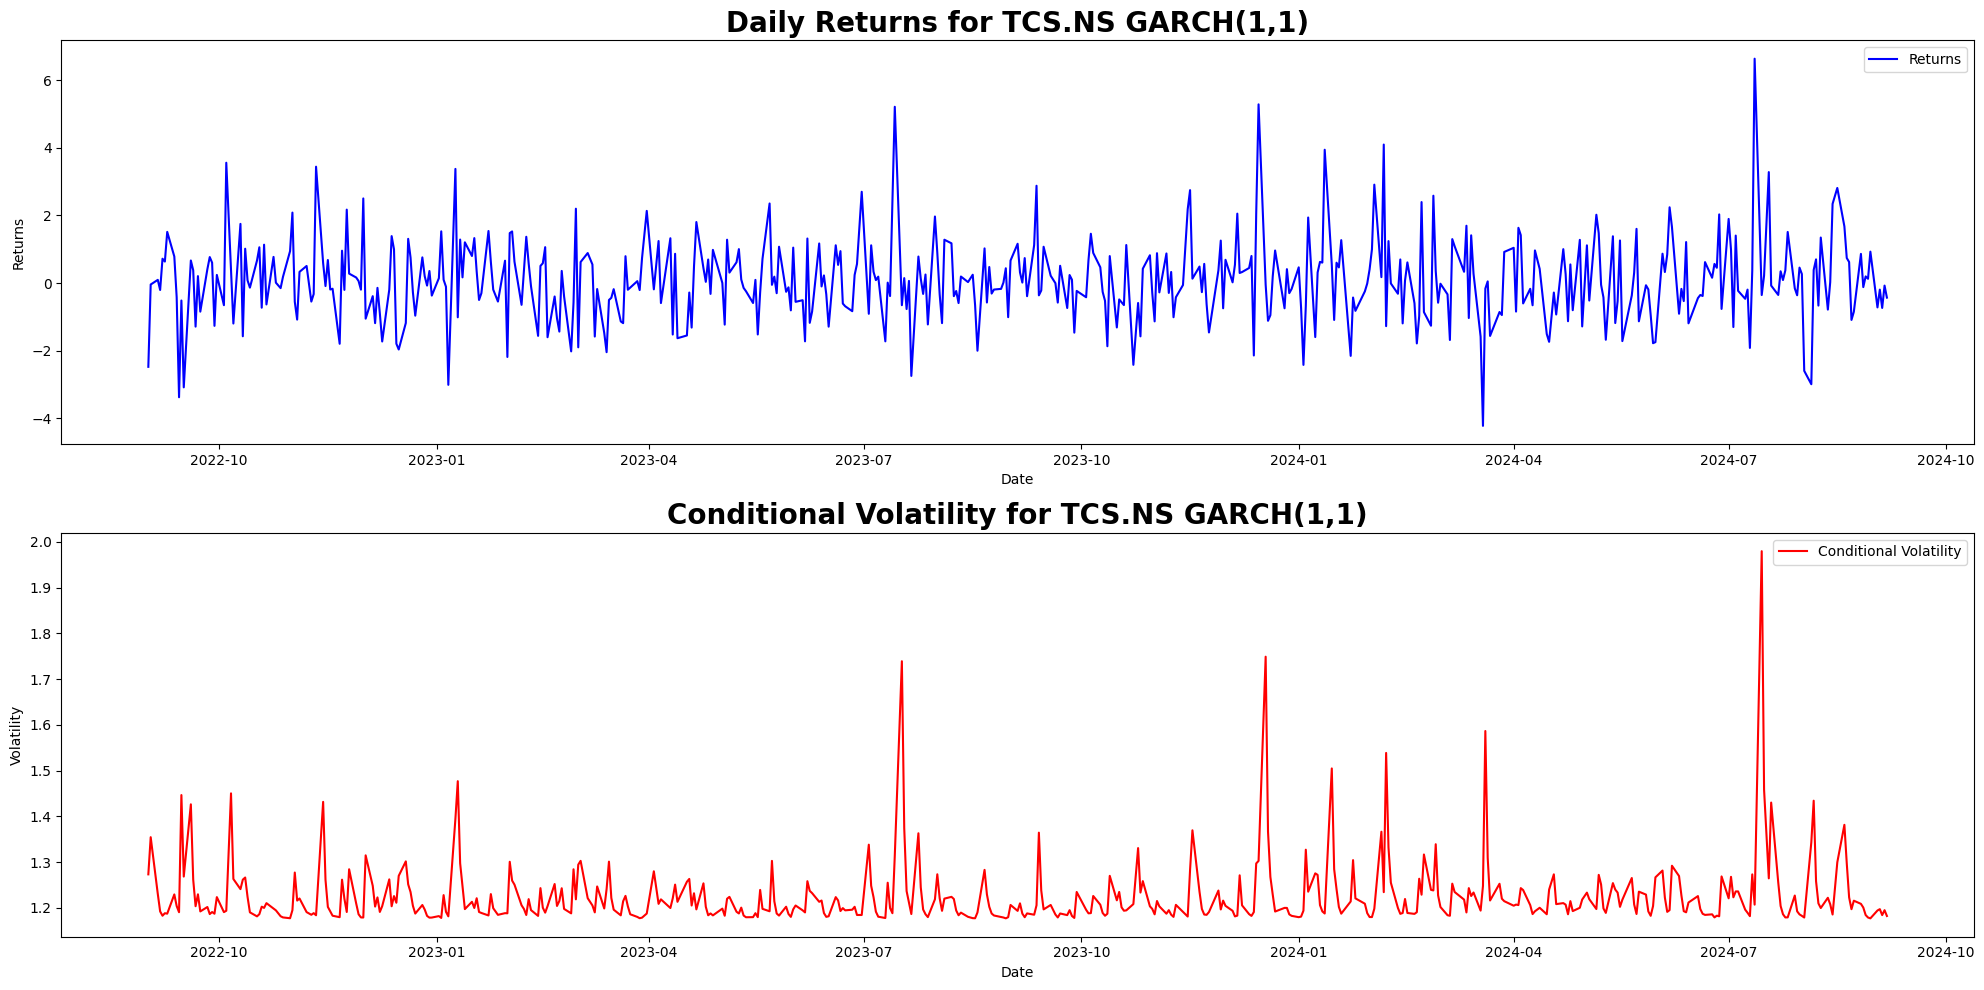

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -805.792
Distribution:                  Normal   AIC:                           1619.58
Method:            Maximum Likelihood   BIC:                           1636.42
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:05   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0756  4.520e

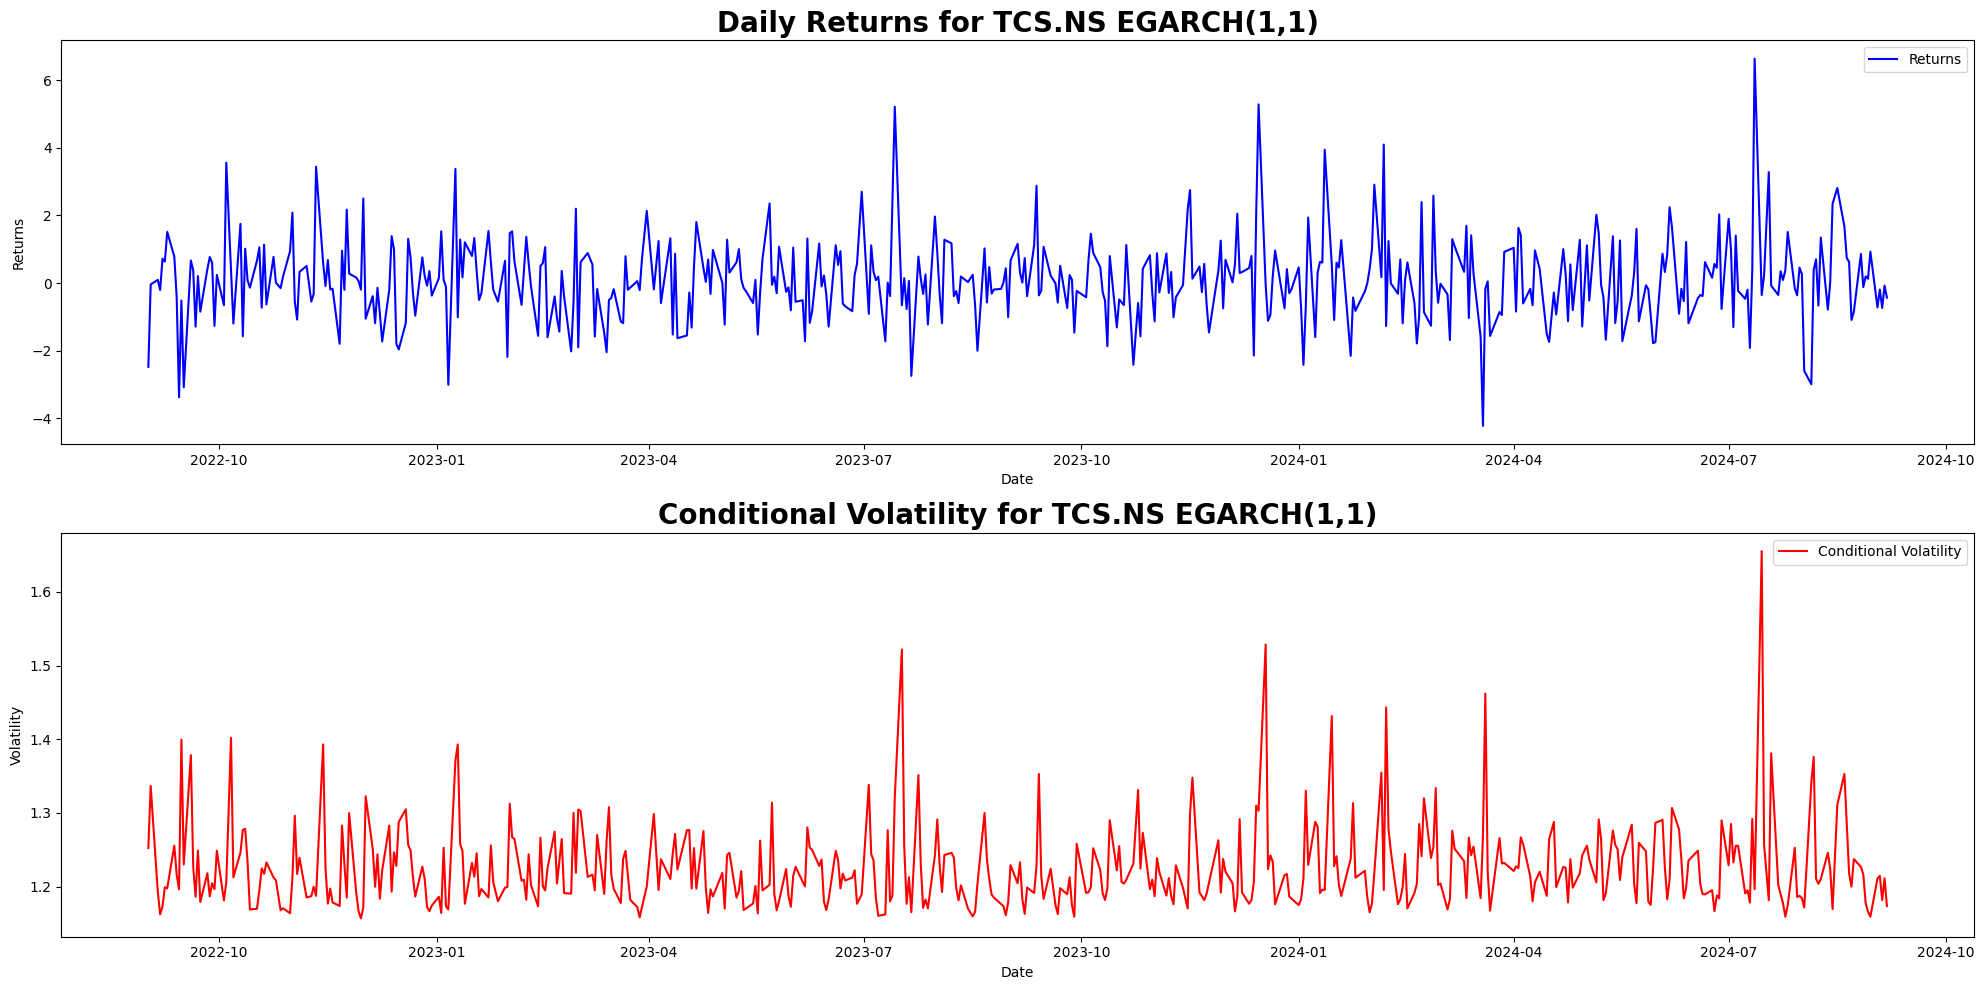

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -805.305
Distribution:                  Normal   AIC:                           1620.61
Method:            Maximum Likelihood   BIC:                           1641.65
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:06   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0796  5.711e-02

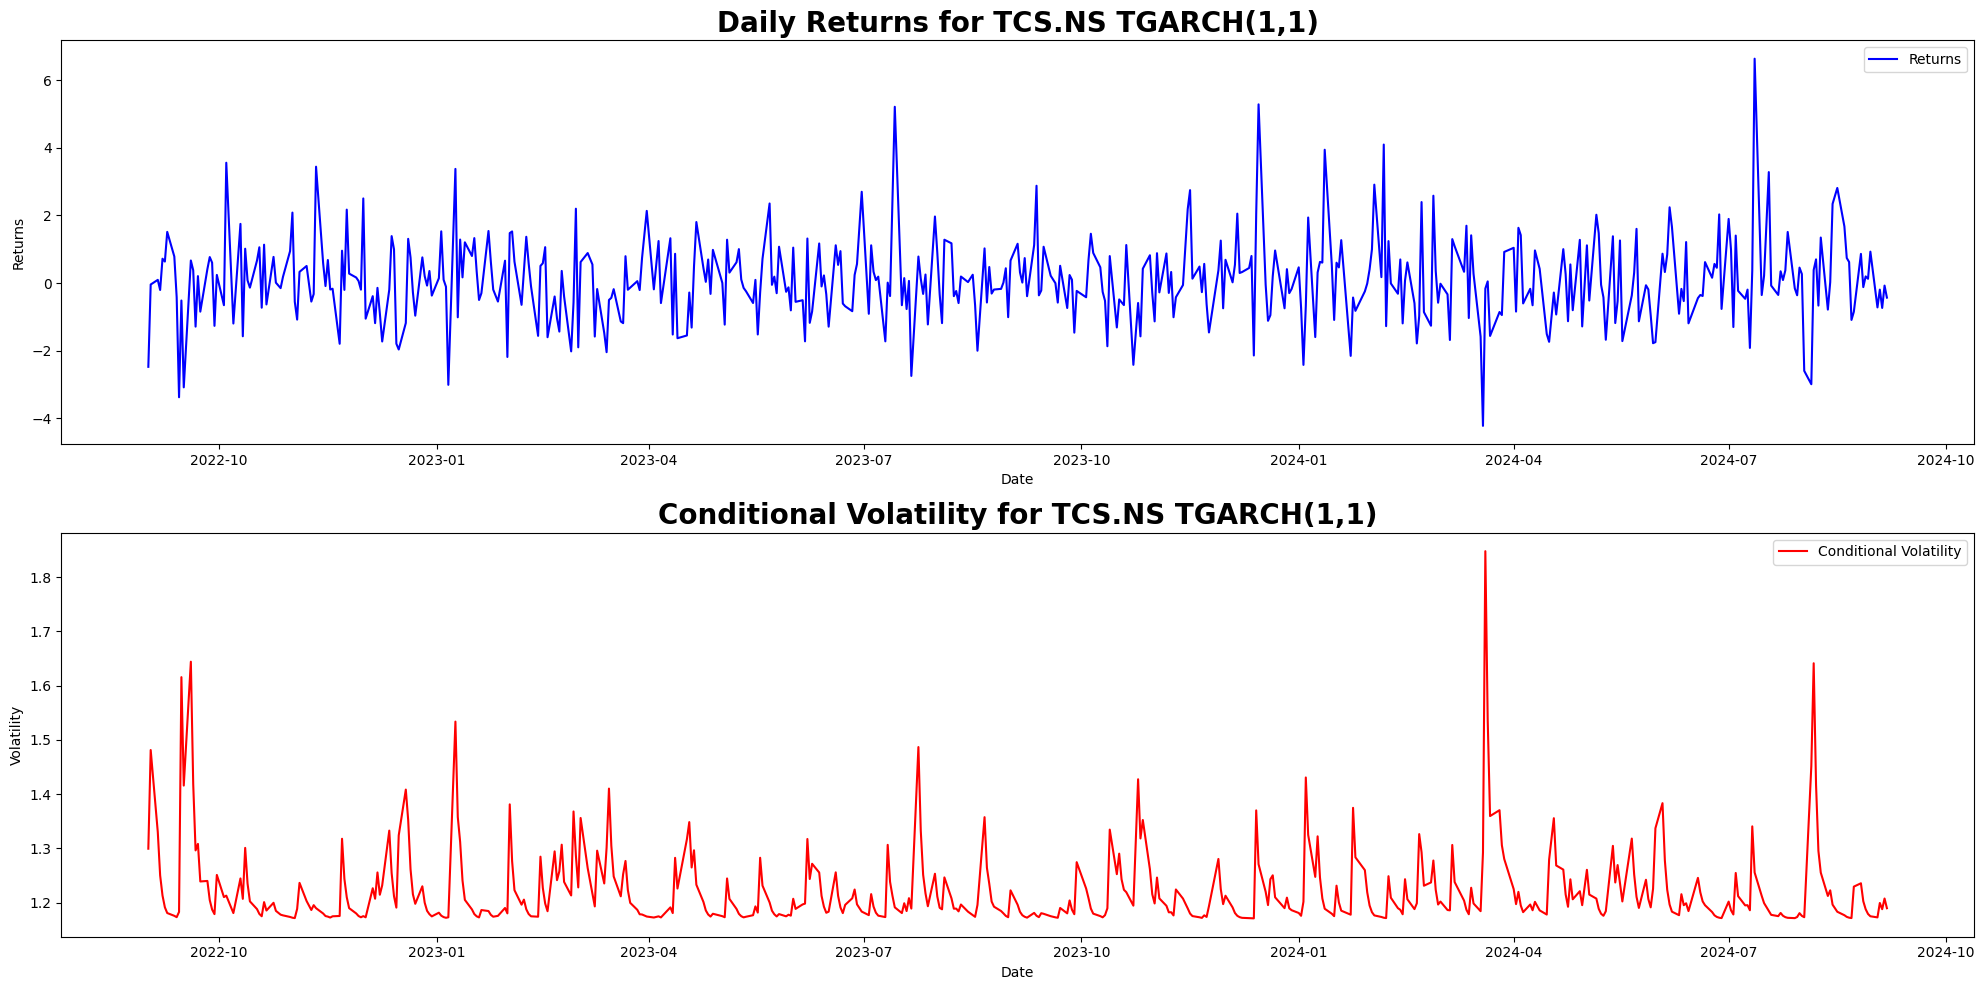

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -805.693
Distribution:                  Normal   AIC:                           1621.39
Method:            Maximum Likelihood   BIC:                           1642.43
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:06   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0772  5.479e-02

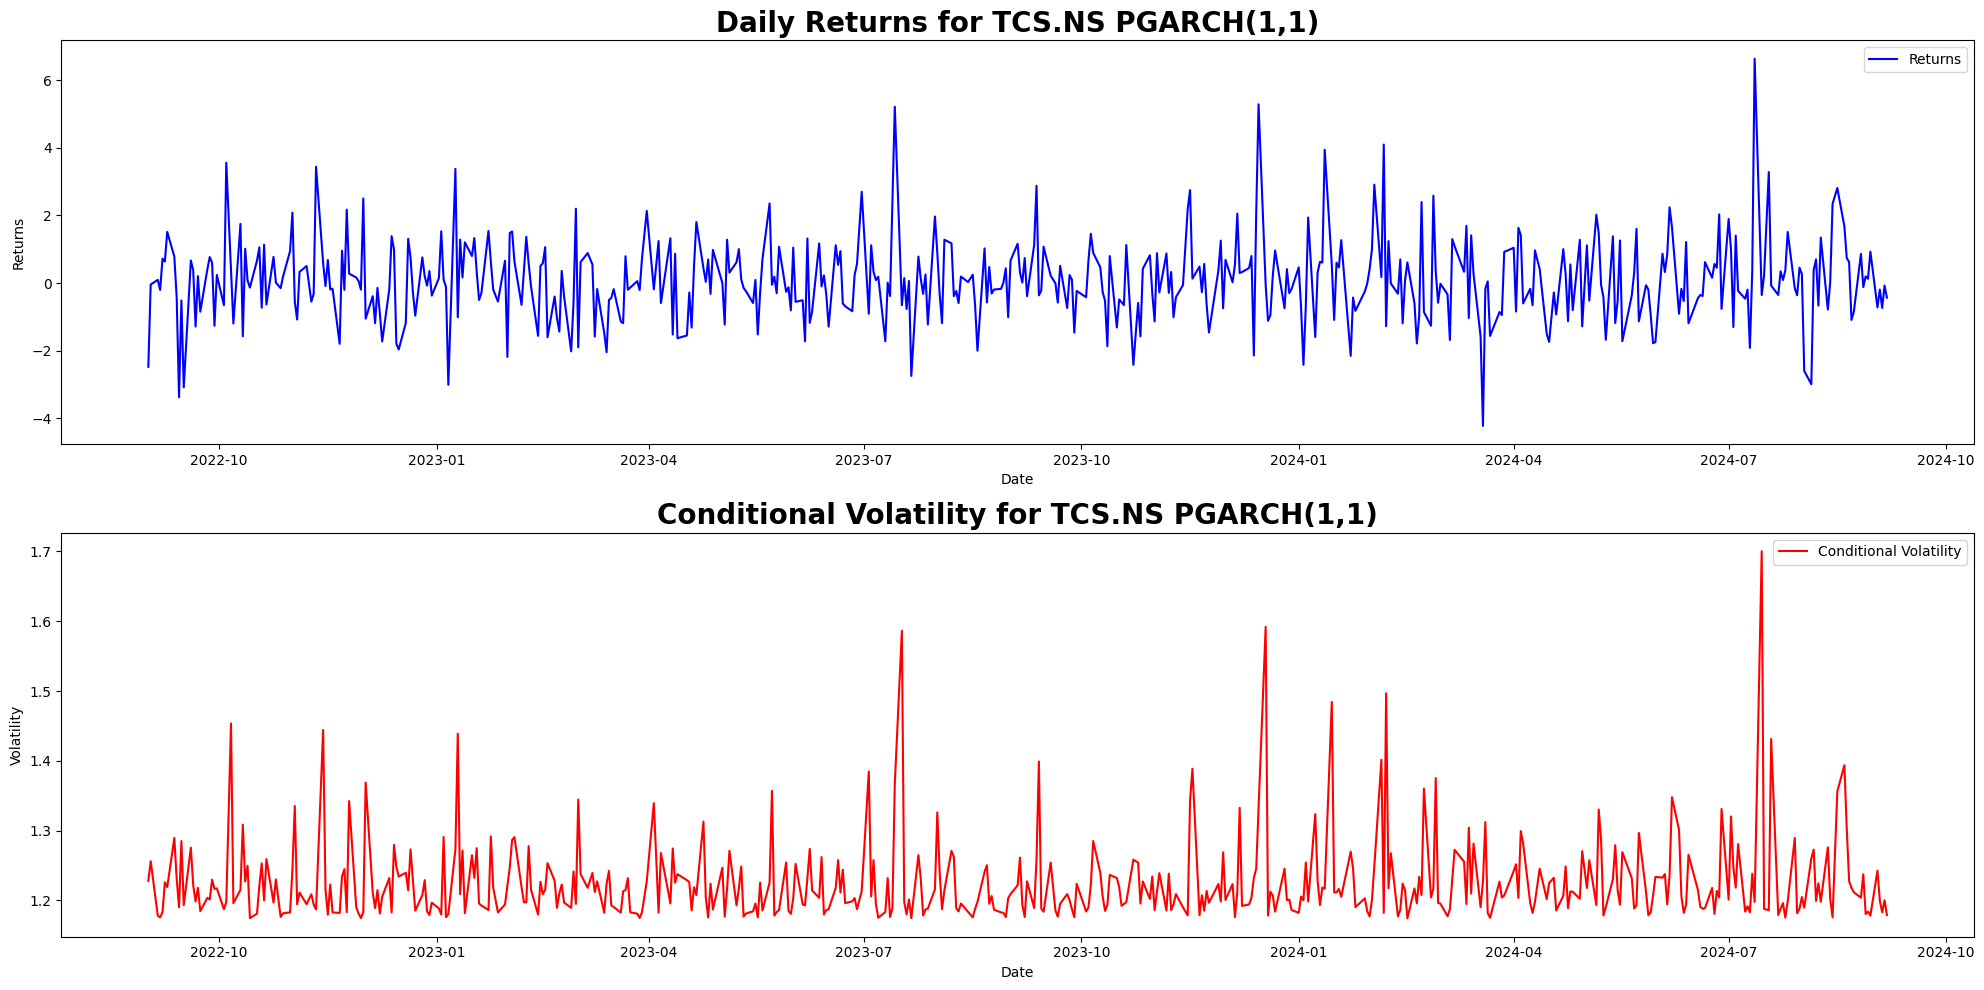


Model Comparisons:
ARCH AIC: 1618.614274825084, BIC: 1631.240044903374
GARCH AIC: 1620.09410527016, BIC: 1636.9284653745465
EGARCH AIC: 1619.5847850549112, BIC: 1636.4191451592976
TGARCH AIC: 1620.6102132194715, BIC: 1641.6531633499546
PGARCH AIC: 1621.3856440470065, BIC: 1642.4285941774897

Best model based on BIC: ARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 11.579840539839495
GARCH - Volatility Forecasting MSE: 11.594308901283053
EGARCH - Volatility Forecasting MSE: 11.559982619434779
TGARCH - Volatility Forecasting MSE: 11.557878604831322
PGARCH - Volatility Forecasting MSE: 11.559177030413606

Best model based on volatility forecasting (lowest mse): TGARCH

**********************************************************Processing COALINDIA.NS*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:               

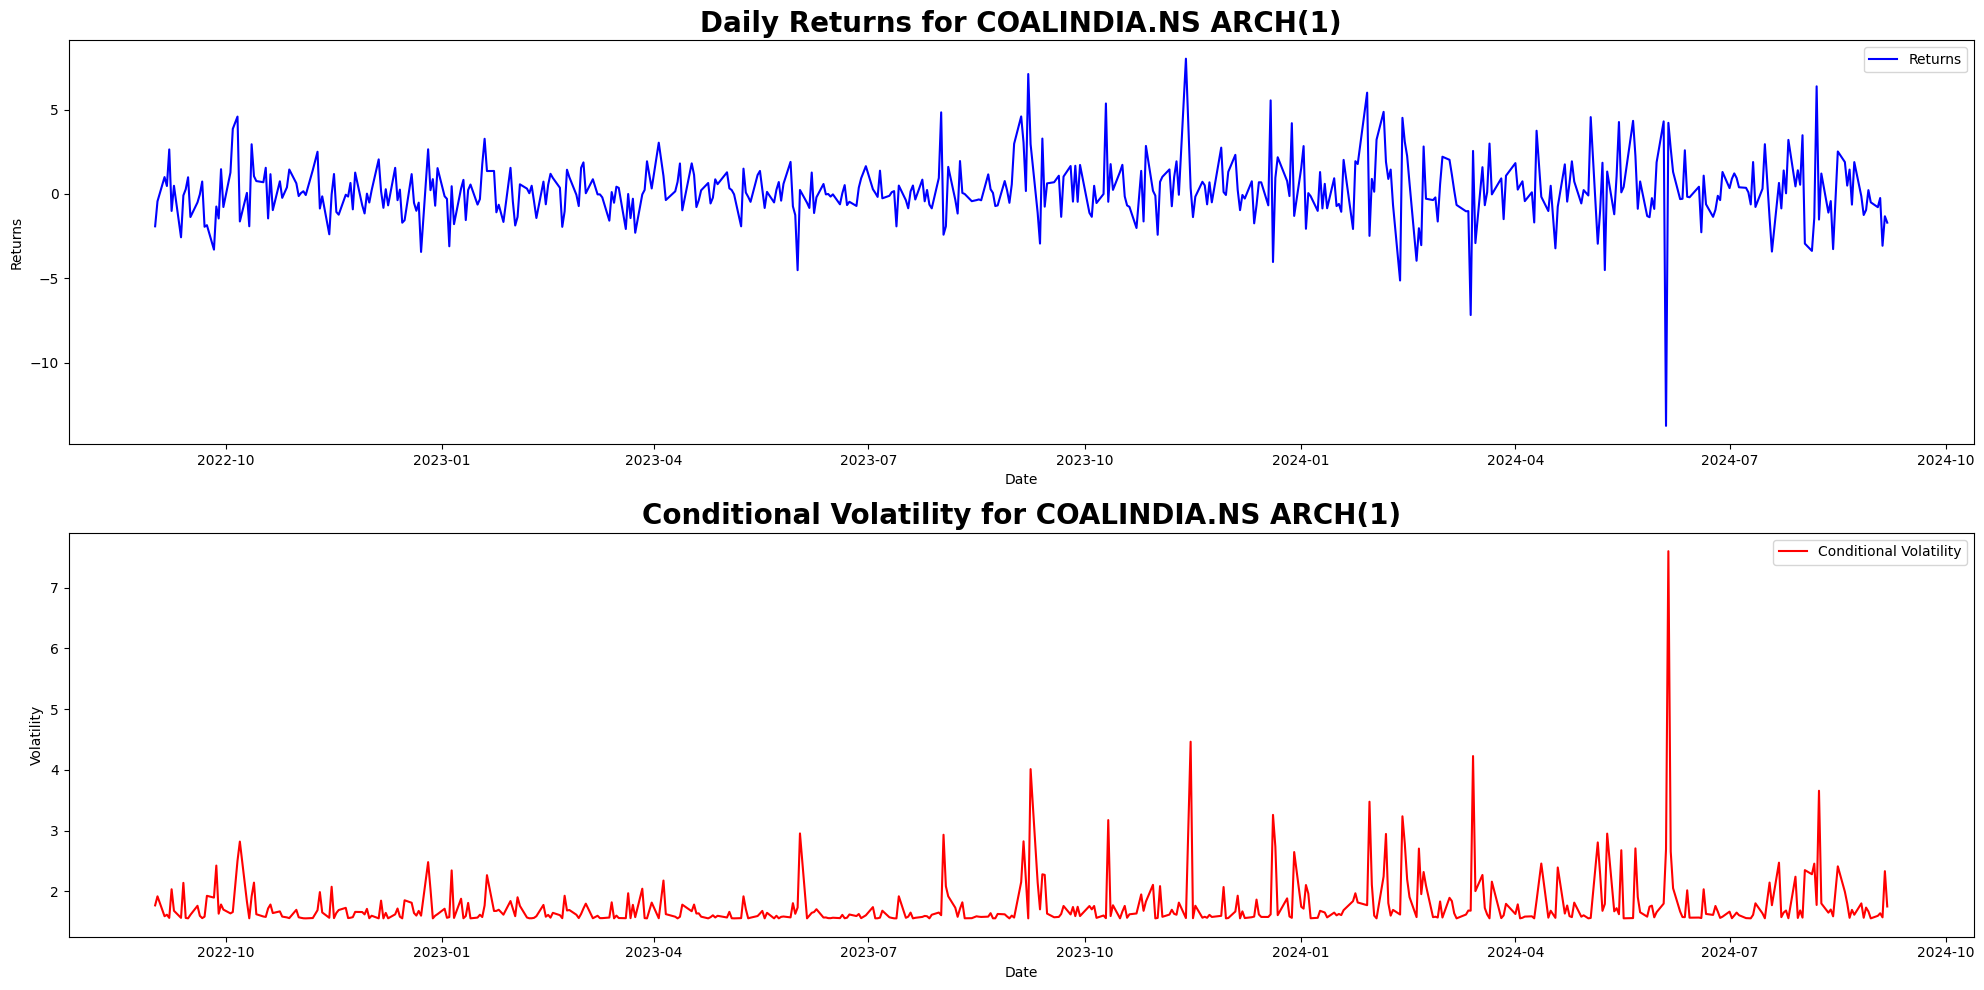

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -977.805
Distribution:                  Normal   AIC:                           1963.61
Method:            Maximum Likelihood   BIC:                           1980.44
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:07   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1577  7.219e-02    

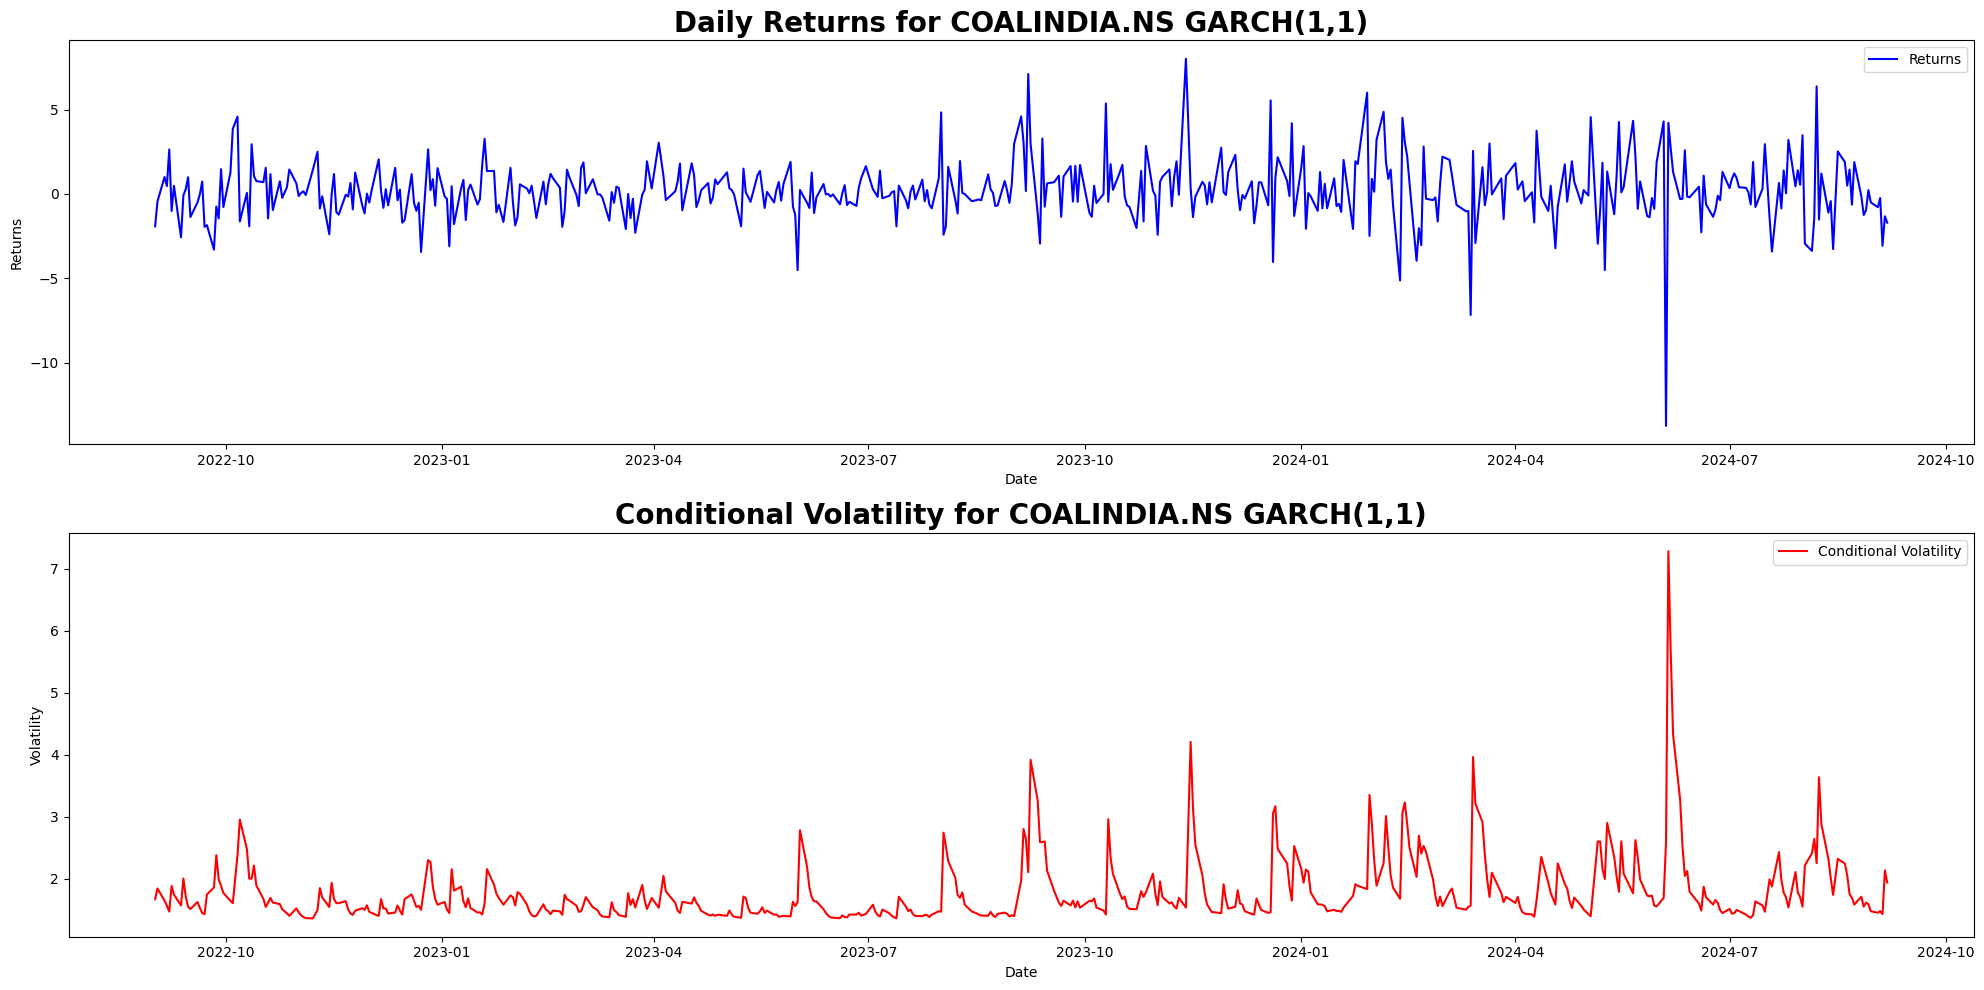

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -975.827
Distribution:                  Normal   AIC:                           1959.65
Method:            Maximum Likelihood   BIC:                           1976.49
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1578  6.968e-02   

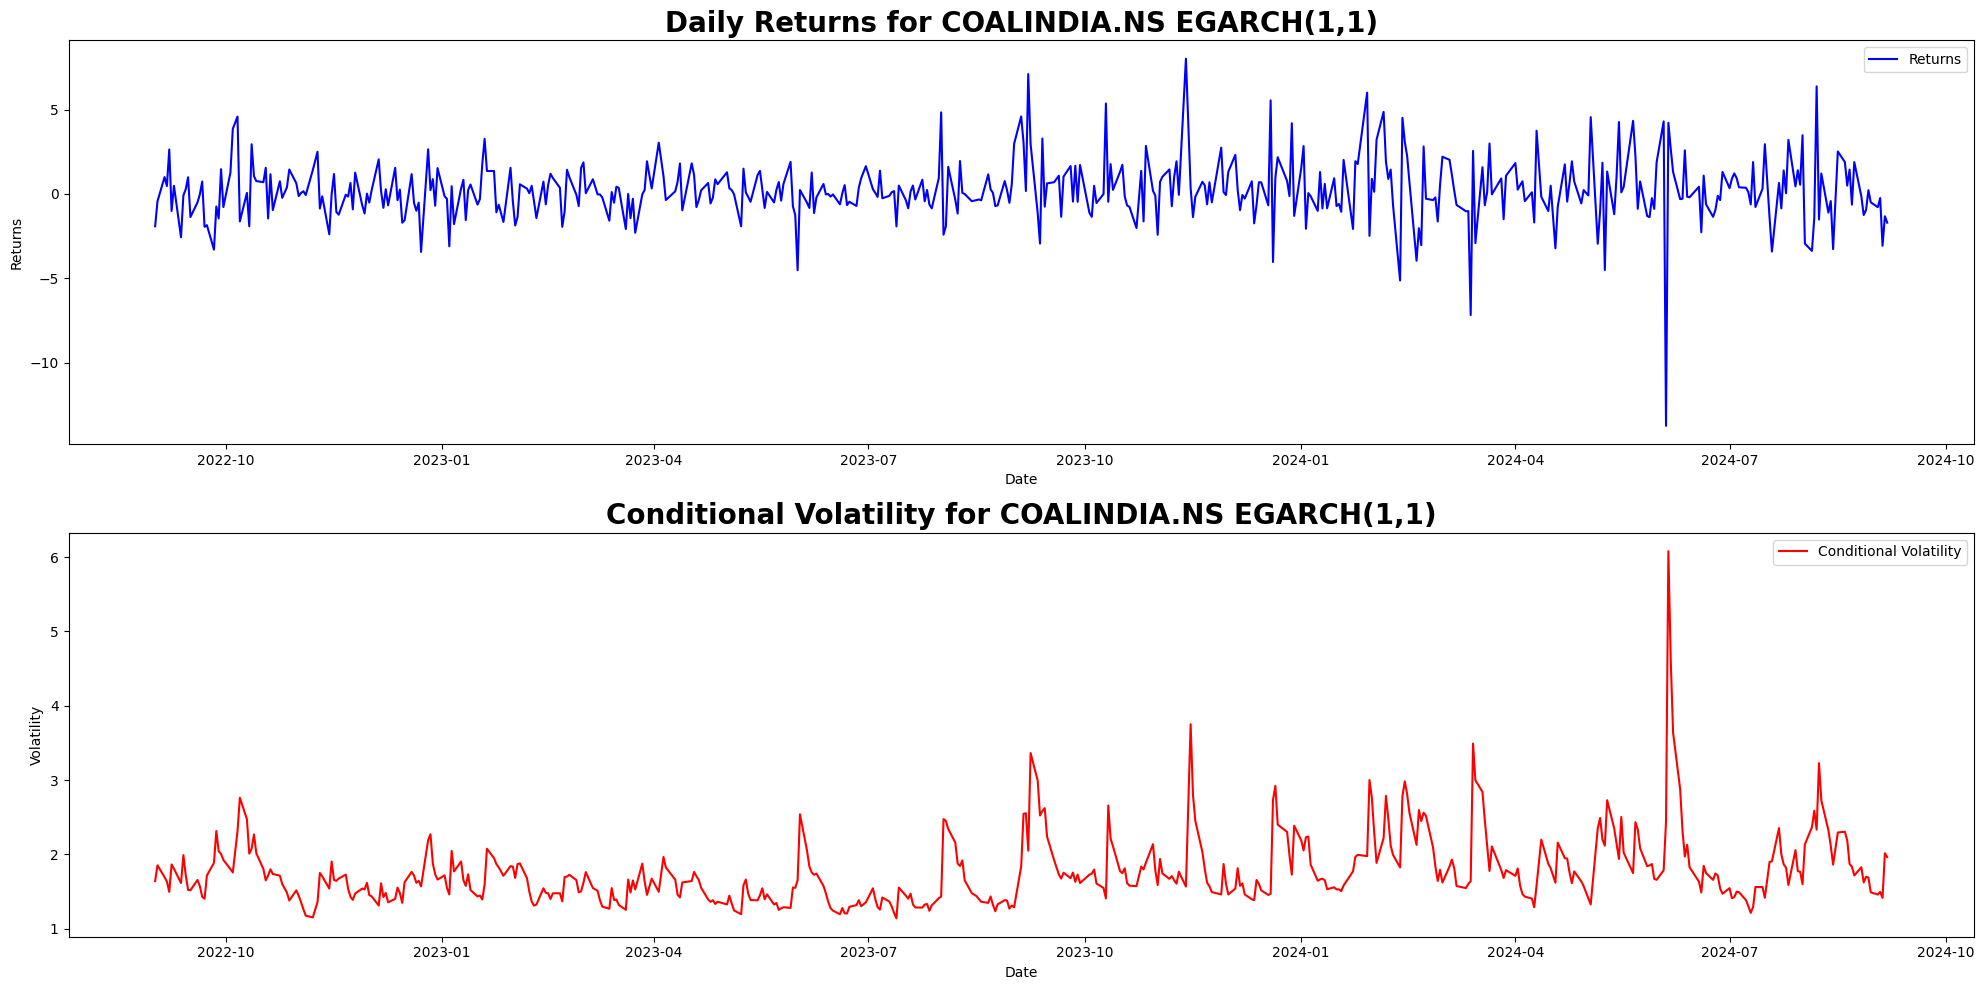

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -973.653
Distribution:                  Normal   AIC:                           1957.31
Method:            Maximum Likelihood   BIC:                           1978.35
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1966  7.083e-02   

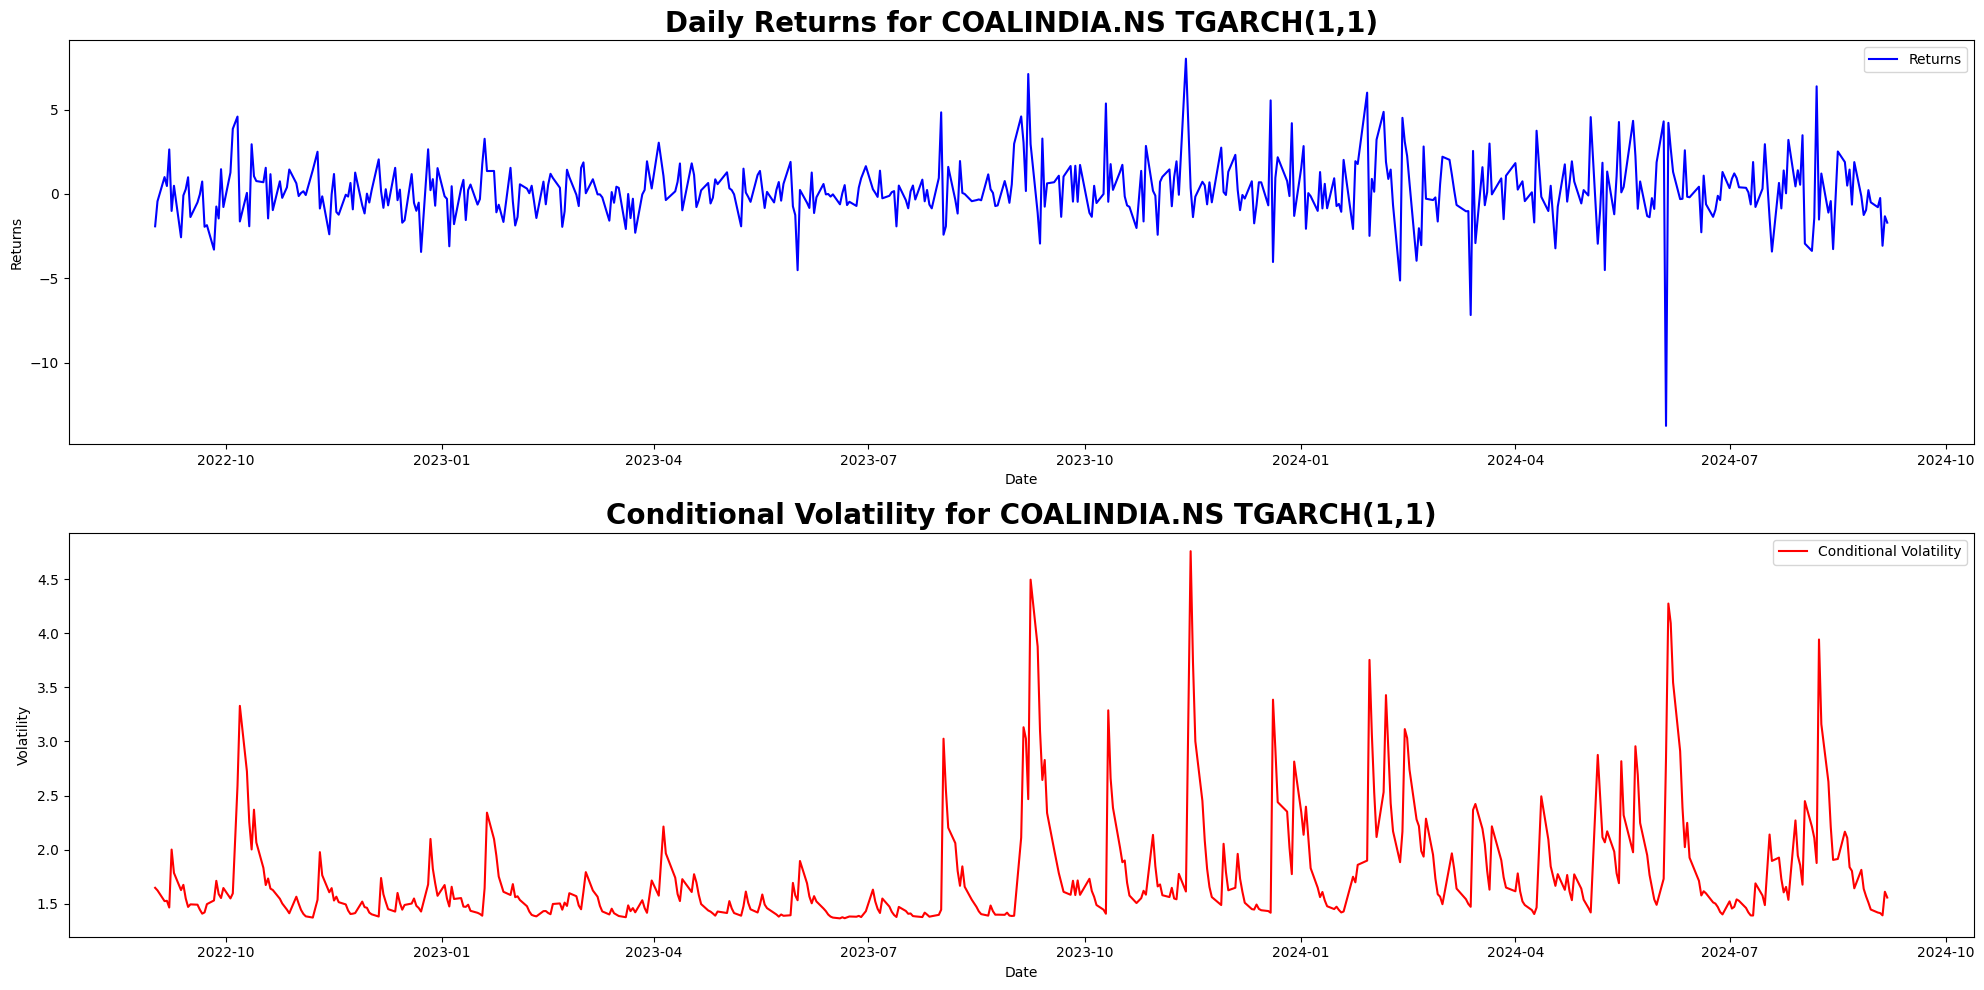

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -972.694
Distribution:                  Normal   AIC:                           1955.39
Method:            Maximum Likelihood   BIC:                           1976.43
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2099  7.676e-02   

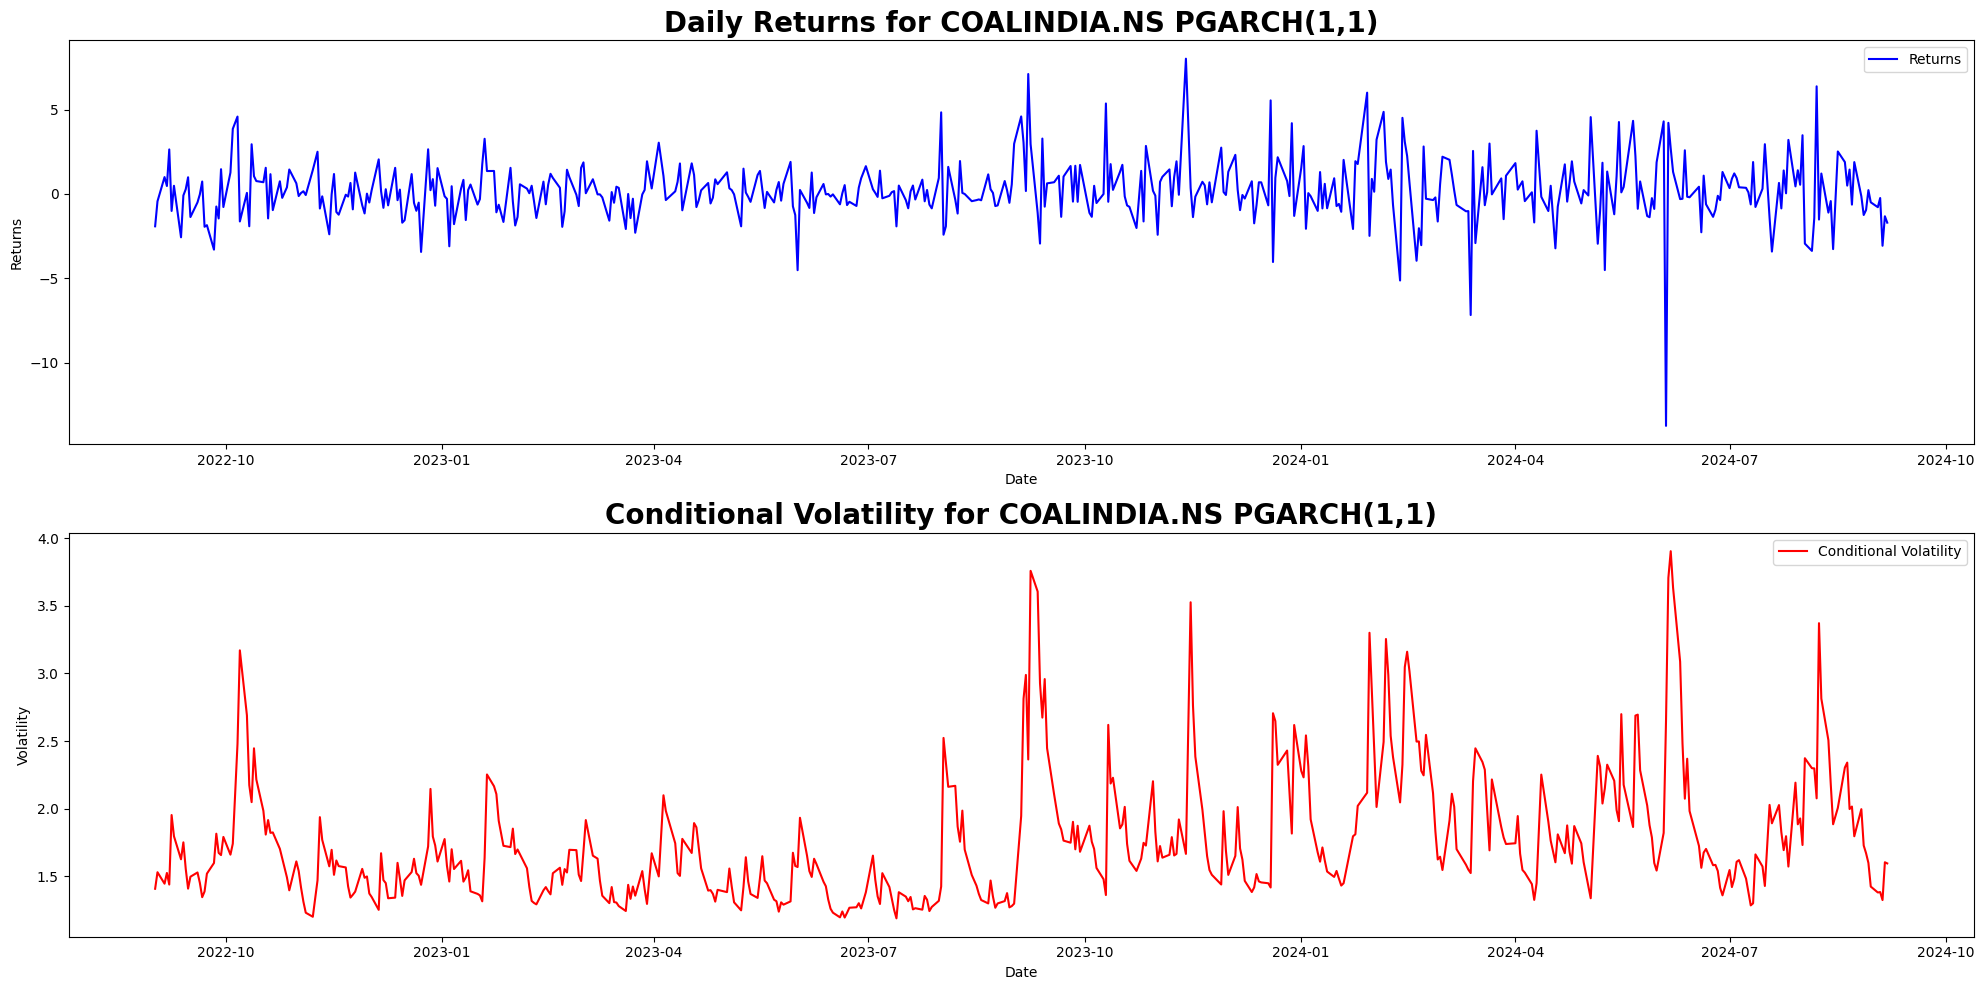


Model Comparisons:
ARCH AIC: 1967.177122648522, BIC: 1979.802892726812
GARCH AIC: 1963.609092941013, BIC: 1980.4434530453993
EGARCH AIC: 1959.6536192708732, BIC: 1976.4879793752596
TGARCH AIC: 1957.3050204839146, BIC: 1978.3479706143978
PGARCH AIC: 1955.3878971832896, BIC: 1976.4308473137728

Best model based on BIC: PGARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 112.95719562081153
GARCH - Volatility Forecasting MSE: 114.66886125352477
EGARCH - Volatility Forecasting MSE: 111.24486967124801
TGARCH - Volatility Forecasting MSE: 110.93134570677911
PGARCH - Volatility Forecasting MSE: 109.8635533889916

Best model based on volatility forecasting (lowest mse): PGARCH

**********************************************************Processing BAJFINANCE.NS*****************************************************************
Fitting ARCH(1) model...
                      Constant Mean - ARCH Model Results                      
Dep. Variable:            

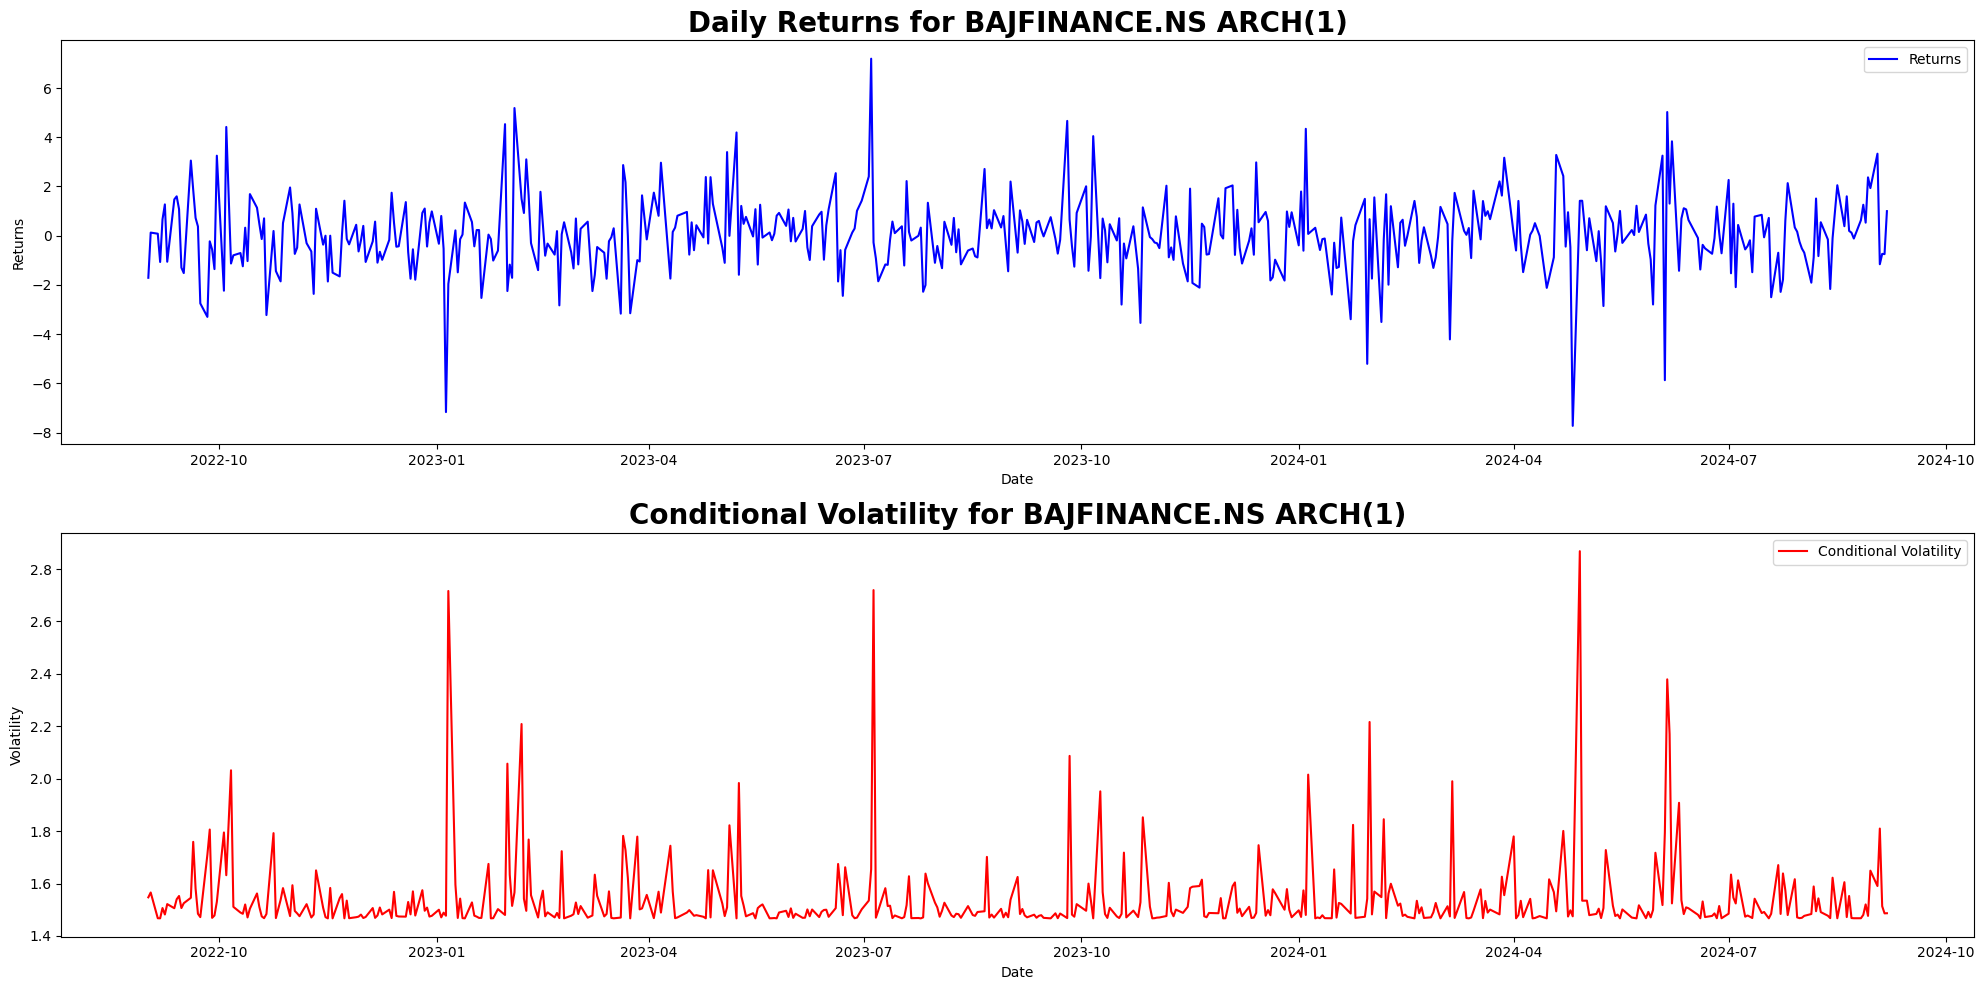

Fitting GARCH(1,1) model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -917.736
Distribution:                  Normal   AIC:                           1843.47
Method:            Maximum Likelihood   BIC:                           1860.31
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:10   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -3.2361e-03  6.847e-02 -4.72

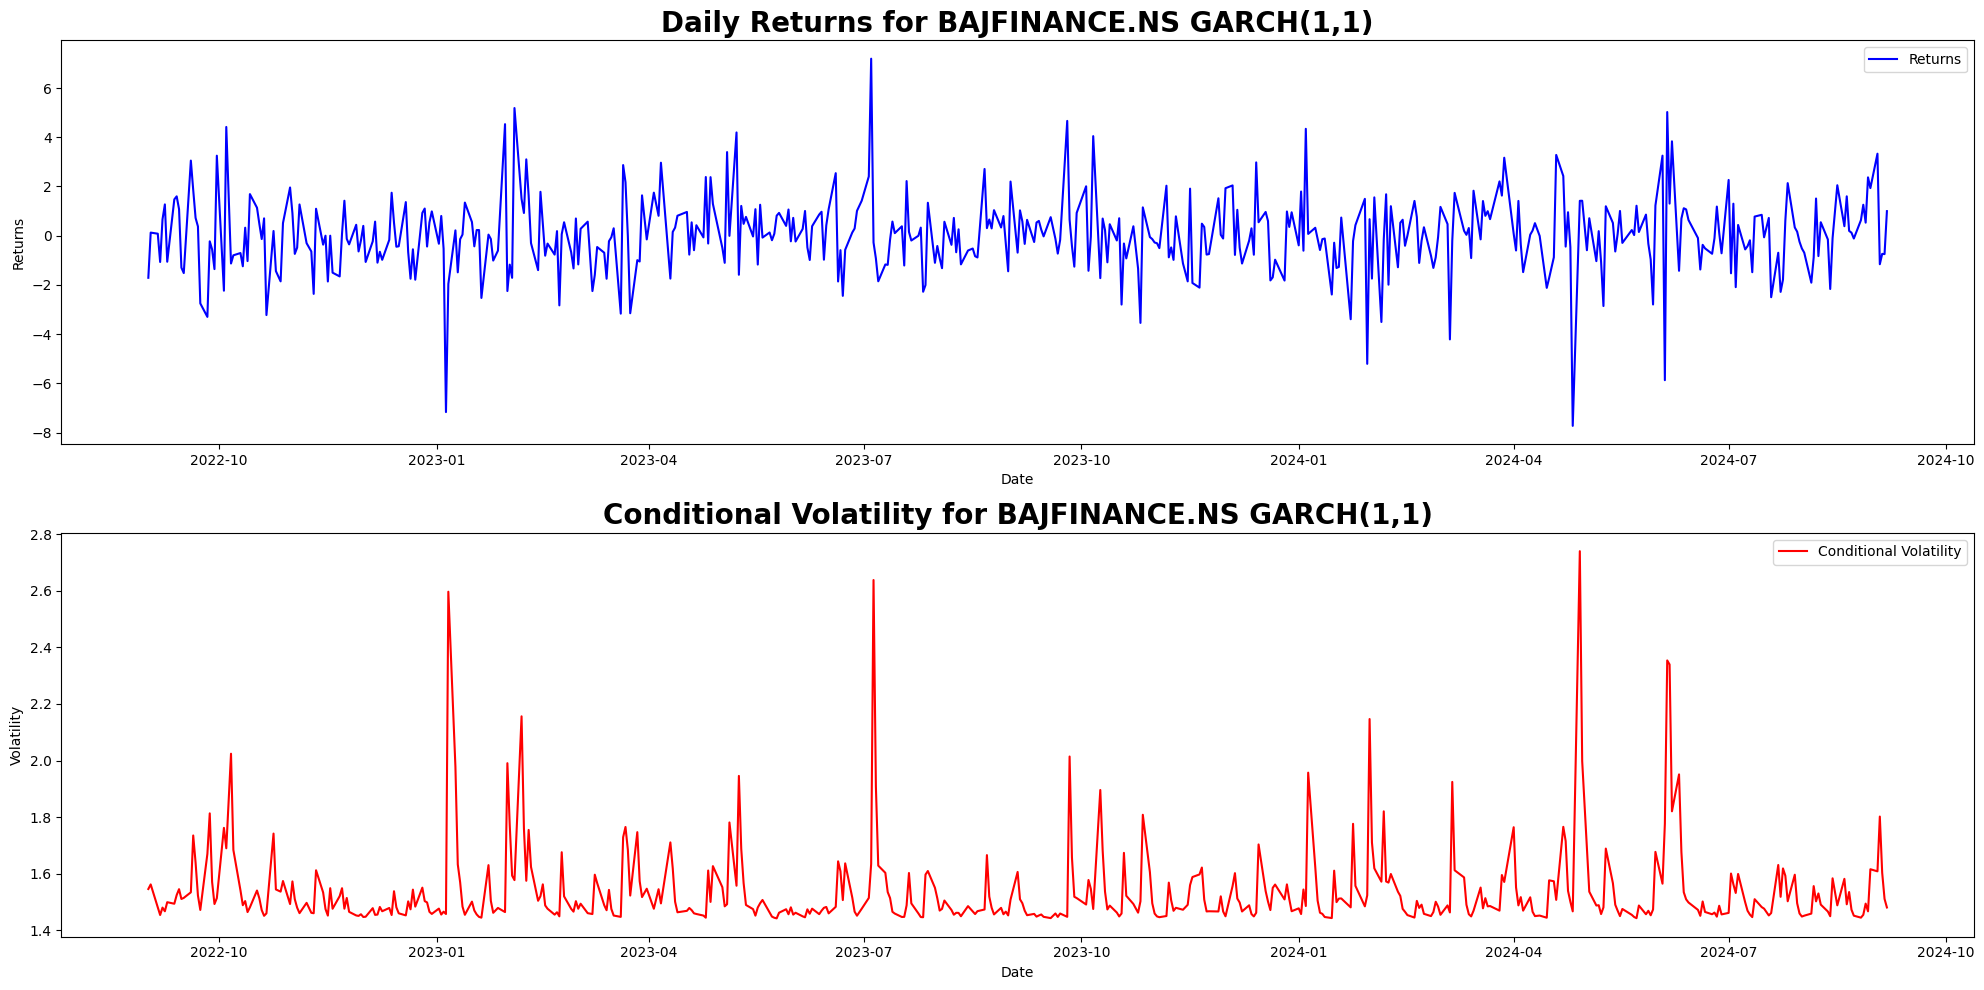

Fitting EGARCH(1,1) model...
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -916.959
Distribution:                  Normal   AIC:                           1841.92
Method:            Maximum Likelihood   BIC:                           1858.75
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:11   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0151  7.114e-02      0.2

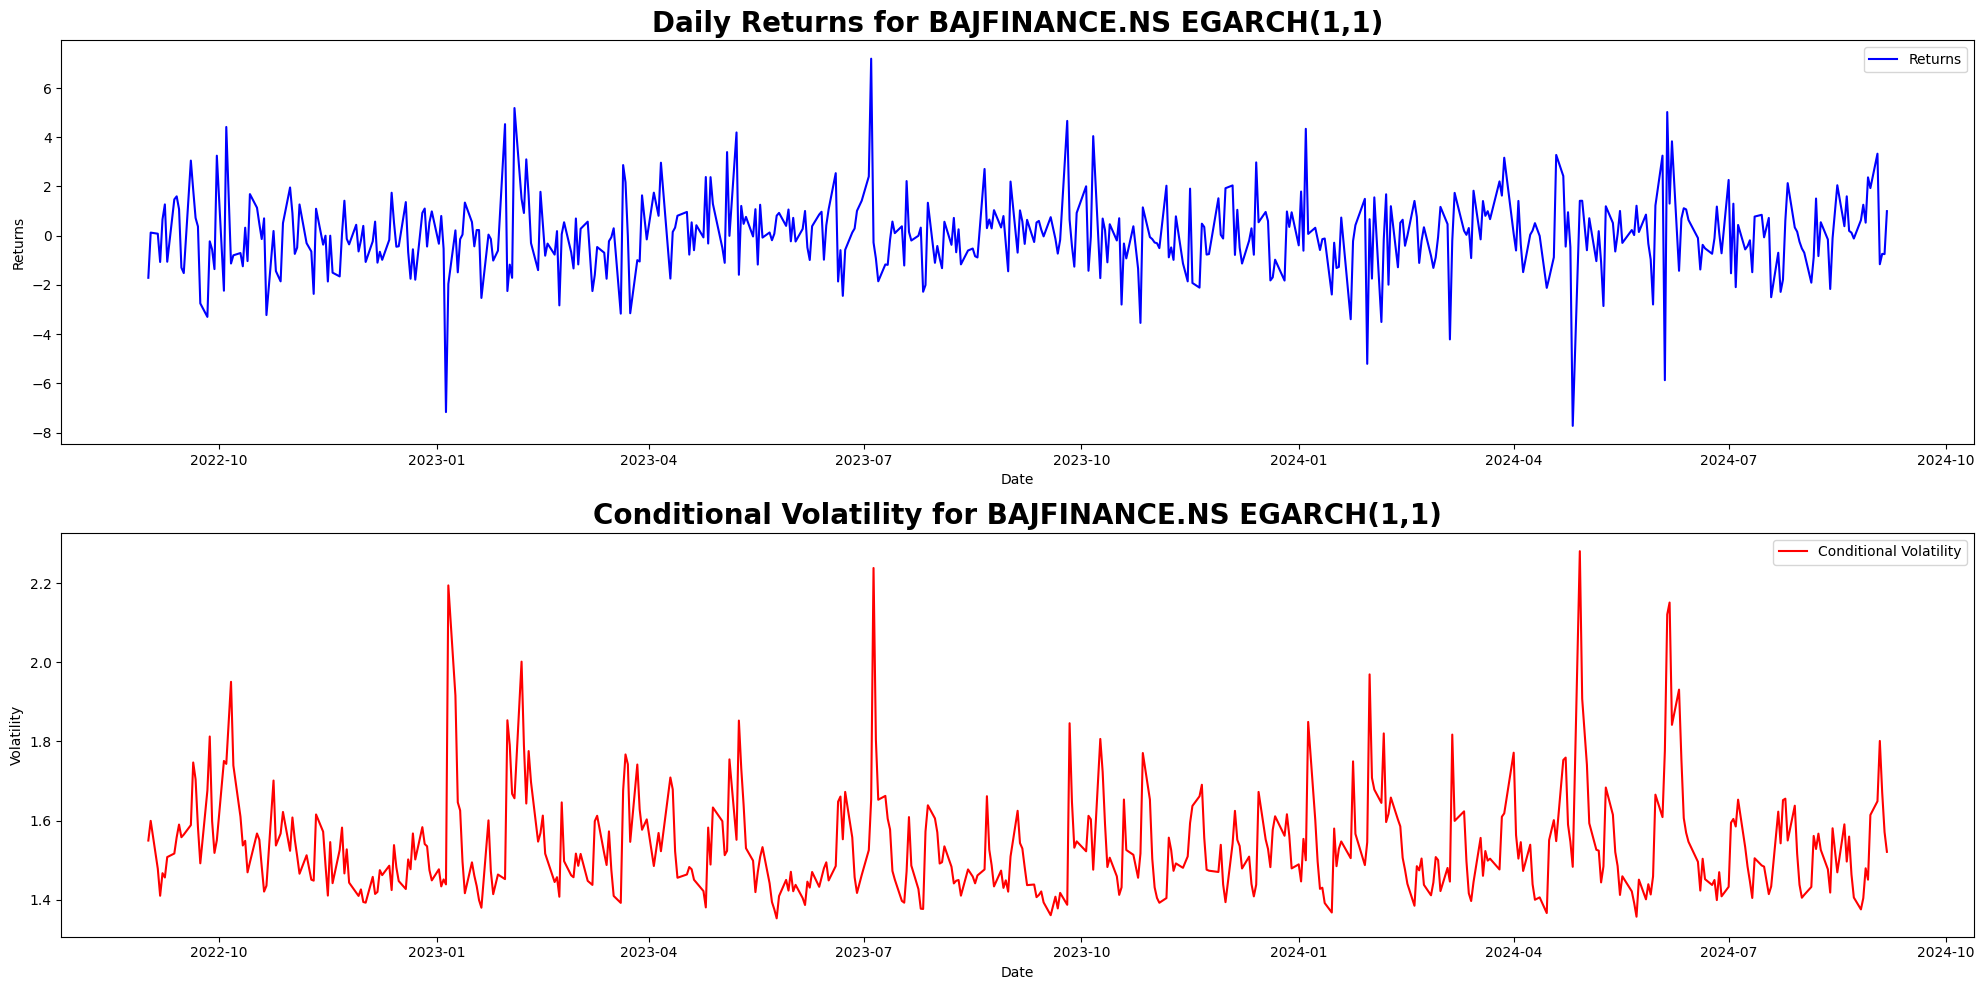

Fitting TGARCH(1,1) model...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -916.589
Distribution:                  Normal   AIC:                           1843.18
Method:            Maximum Likelihood   BIC:                           1864.22
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:11   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu         2.8055e-03  6.775e-02  4.141e-

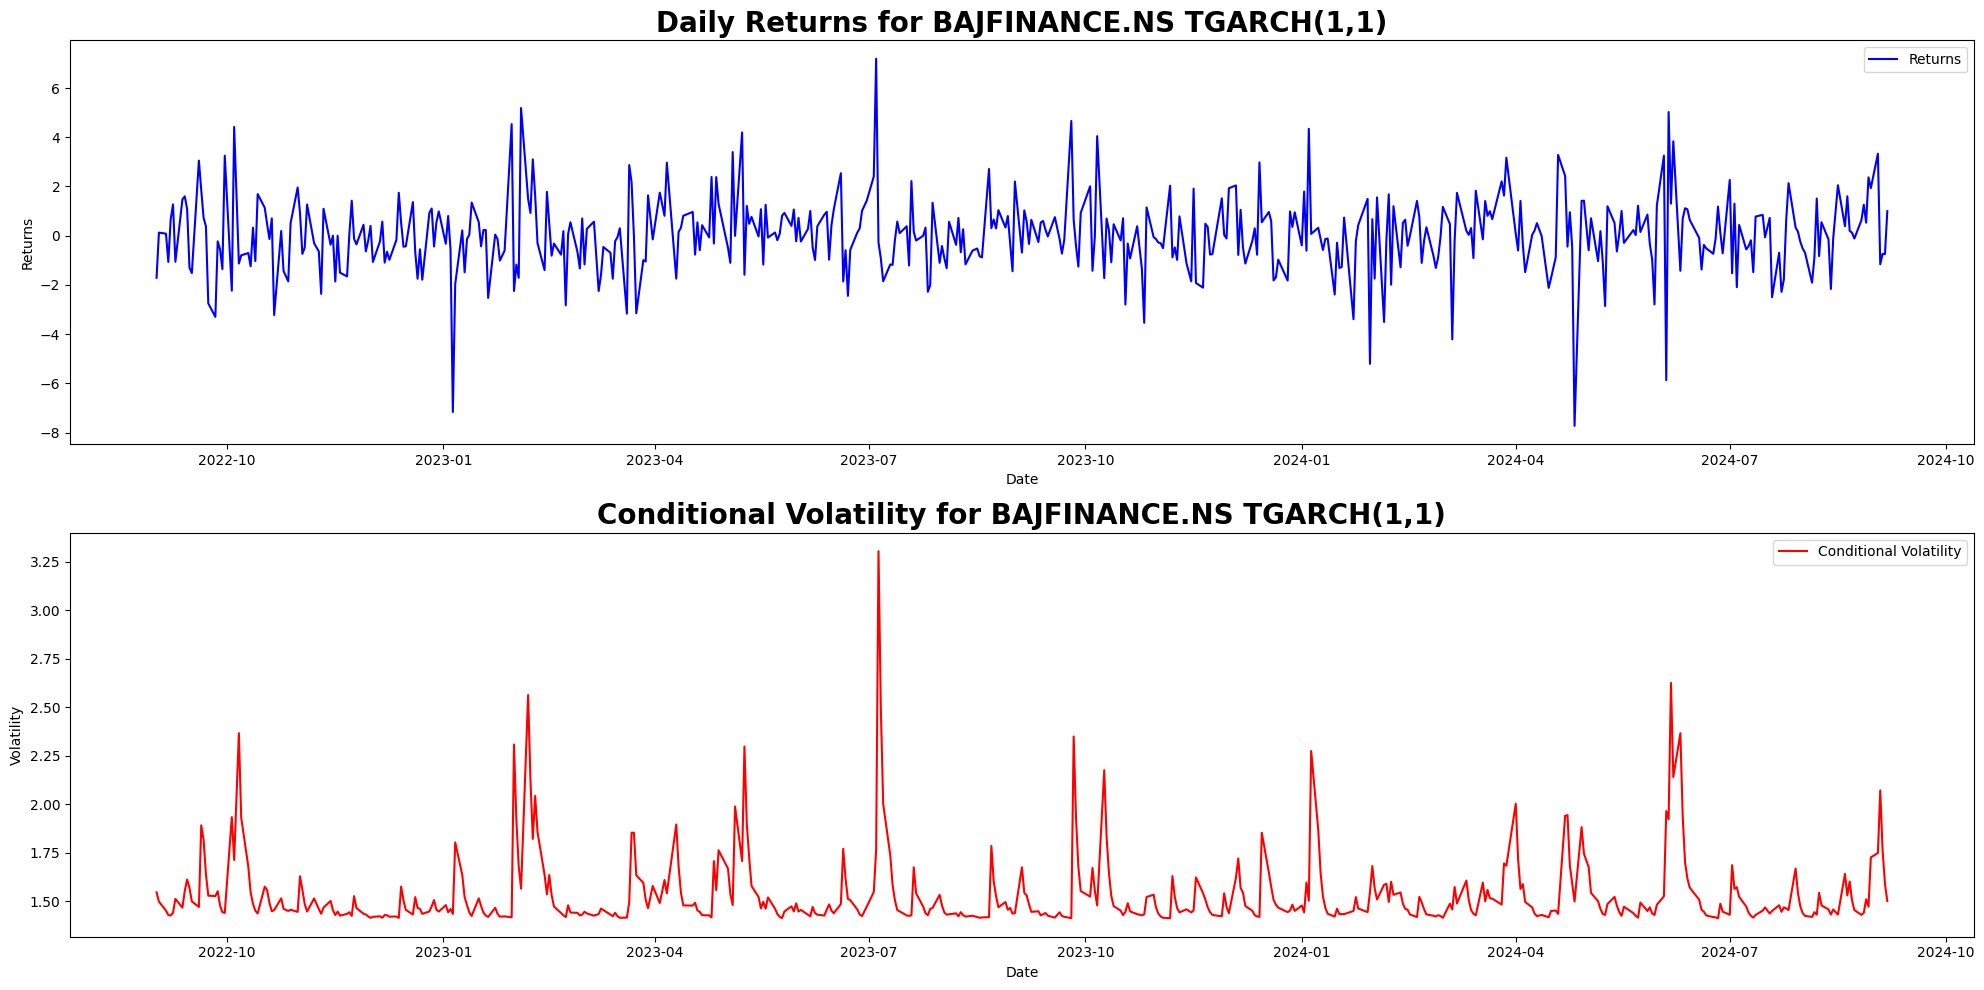

Fitting PGARCH(1,1) model...
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -916.060
Distribution:                  Normal   AIC:                           1842.12
Method:            Maximum Likelihood   BIC:                           1863.16
                                        No. Observations:                  497
Date:                Sat, Sep 07 2024   Df Residuals:                      496
Time:                        20:10:12   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0248  7.243e-02      0.3

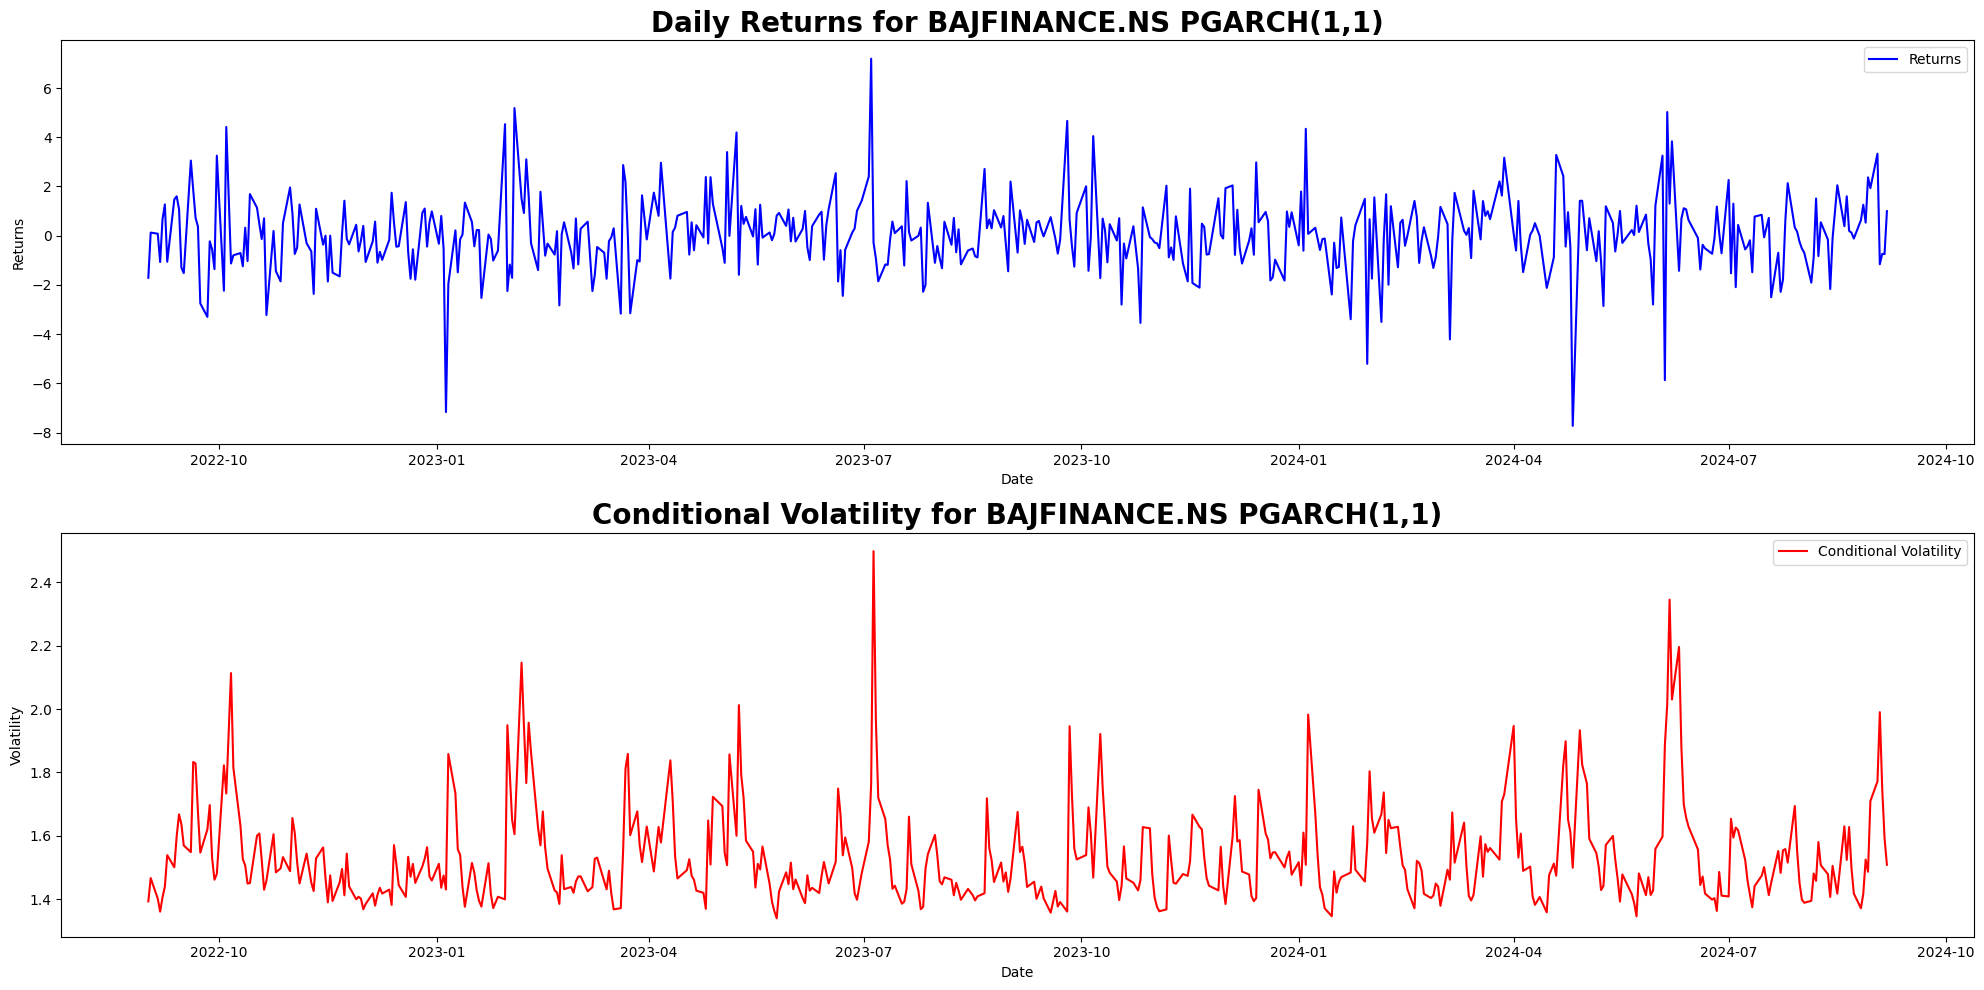


Model Comparisons:
ARCH AIC: 1841.9278396797808, BIC: 1854.5536097580707
GARCH AIC: 1843.4723447869778, BIC: 1860.3067048913642
EGARCH AIC: 1841.917238364929, BIC: 1858.7515984693155
TGARCH AIC: 1843.1787132736674, BIC: 1864.2216634041506
PGARCH AIC: 1842.120045353808, BIC: 1863.1629954842913

Best model based on BIC: ARCH

Comparing models based on volatility forecasting...
ARCH - Volatility Forecasting MSE: 32.0599508425907
GARCH - Volatility Forecasting MSE: 32.02554627106747
EGARCH - Volatility Forecasting MSE: 31.92403591329105
TGARCH - Volatility Forecasting MSE: 32.222930254099964
PGARCH - Volatility Forecasting MSE: 31.89102989564405

Best model based on volatility forecasting (lowest mse): PGARCH


In [75]:
for stock_name, df in stock_data.items():
    returns = calculate_returns(df)
    evaluate_and_visualize_models(returns, stock_name)

The results indicate that different models perform best depending on the evaluation metric (BIC or volatility forecast) for each stock. For Bajaj Finance, while the ARCH model had the lowest BIC, indicating it fits the data well, PGARCH provided the best volatility forecast, suggesting it captures more nuances in volatility dynamics over time. In the case of Coal India, PGARCH was the best model both in terms of BIC and volatility forecasting, meaning it not only fits the data well but also excels at predicting future volatility. Finally, for TCS, the ARCH model had the lowest BIC, suggesting it offers a simpler, better-fitting model, but TGARCH produced better volatility forecasts, likely because TCS exhibits asymmetric volatility patterns that TGARCH is better equipped to capture. 